<h1>Sobre este estudo</h1>

Este é um estudo realizado sobre acidentes aéreos. Os dados utilizados nesse estudo foram disponibilizados pela CENIPA - Centro de Investigação e Prevenção de Acidentes aeronáuticos. Esses dados podem ser acessados em <a href='http://dados.gov.br/dataset/ocorrencias-aeronauticas-da-aviacao-civil-brasileira'>http://dados.gov.br/dataset/ocorrencias-aeronauticas-da-aviacao-civil-brasileira</a>.
Constam nesta base de dados as ocorrências aeronáuticas notificadas ao CENIPA no anos de 2012 a 2021 que ocorreram em solo brasileiro. A seguir são apresentadas as tabelas e o relacionamento entre elas:
<br>
<br>OCORRÊNCIA.csv - Informações sobre as ocorrências.
<br>OCORRÊNCIA_TIPO.csv - Informações sobre o tipo de ocorrência.
<br>AERONAVE.csv - Informações sobre as aeronaves envolvidas nas ocorrências.
<br>FATOR_CONTRIBUINTE.csv - Informações sobre os fatores contribuinte das ocorrências que tiveram investigações finalizadas.
<br>RECOMENDAÇÃO.csv - Informações sobre as recomendações de segurança geradas nas ocorrências.

<img src='./img/relacionamento_tabelas.png'>

<br>
<br>OBS.:
<br>codigo_ocorrencia : ocorrencia
<br>codigo_ocorrencia1 : ocorrencia_tipo
<br>codigo_ocorrencia2 : ocorrencia_aeronave
<br>codigo_ocorrencia3 : ocorrencia_fator
<br>codigo_ocorrencia4 : ocorrencia_recomendação

<h1> Hipótese </h1>

<b> Os dados utilizados podem ser utilizados para montar um modelo capaz de definir a classificação da ocorrência? <b>

<h1>Importando bibliotecas e setando colors</h1>

In [1]:
%matplotlib inline
import pandas as pd #Para criação de DataFrames
import matplotlib.pyplot as plt #Para plotagem
import random

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection._search import GridSearchCV

In [2]:
#Cores para serem usadas nos gráficos
colors = [['#0D47A1','#1565C0','#1976D2','#1E88E5','#2196F3'],
          ['#311B92','#512DA8','#673AB7','#9575CD','#B39DDB'],
          ['#1B5E20','#388E3C','#4CAF50','#81C784','#66BB6A'],
          ['#E65100','#EF6C00','#F57C00','#FB8C00','#FF9800'],
          ['#3E2723','#4E342E','#5D4037','#6D4C41','#795548'],
          ['#BF360C','#D84315','#E64A19','#F4511E','#FF5722'],
          ['#880E4F','#AD1457','#C2185B','#D81B60','#E91E63']
         ]

<h2> Util </h2>

In [3]:
#Função que converte todos os valo nulos (NaN) para o numeral 0.
def convert_na(dataframe, column):
    for i in column:
        dataframe[i].fillna(0, inplace = True)
        
# Função que converte uma coluna para o dtype desejado 
def convert_dtype(dataframe, column, dtype):
    for i in column:
        dataframe[i] = dataframe[i].astype(dtype)

<h2>Leitura dos dataset</h2>

In [4]:
aeronave = pd.read_csv('./dataset/aeronave.csv', sep=';')
fator_contribuinte = pd.read_csv('./dataset/fator_contribuinte.csv', sep=';')
ocorrencia = pd.read_csv('./dataset/ocorrencia.csv', sep=';')
tipo = pd.read_csv('./dataset/ocorrencia_tipo.csv', sep=';')
recomendacao = pd.read_csv('./dataset/recomendacao.csv', sep=';')

In [5]:
print('O arquivo \"aeronave.csv\" ' + str(aeronave.shape[0]) + ' linhas e ' + str(aeronave.shape[1]) + ' colunas')
print('O arquivo \"fator_contribuinte.csv\" ' + str(fator_contribuinte.shape[0]) + ' linhas e ' + str(fator_contribuinte.shape[1]) + ' colunas')
print('O arquivo \"ocorrencia.csv\" ' + str(ocorrencia.shape[0]) + ' linhas e ' + str(ocorrencia.shape[1]) + ' colunas')
print('O arquivo \"ocorrencia_tipo.csv\" ' + str(tipo.shape[0]) + ' linhas e ' + str(tipo.shape[1]) + ' colunas')
print('O arquivo \"recomendacao.csv\" ' + str(recomendacao.shape[0]) + ' linhas e ' + str(recomendacao.shape[1]) + ' colunas')

O arquivo "aeronave.csv" 5235 linhas e 23 colunas
O arquivo "fator_contribuinte.csv" 3464 linhas e 5 colunas
O arquivo "ocorrencia.csv" 5167 linhas e 22 colunas
O arquivo "ocorrencia_tipo.csv" 5347 linhas e 4 colunas
O arquivo "recomendacao.csv" 1197 linhas e 9 colunas


<h1>Ocorrencia</h1>

<h3> Limpeza de Dados (Data Cleaning) </h3>

In [6]:
ocorrencia

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
0,52242,52242,52242,52242,52242,INCIDENTE,NaN,NaN,PORTO ALEGRE,RS,...,05/01/2012,20:27:00,***,FINALIZADA,***,NÃO,NaN,0,1,NÃO
1,45331,45331,45331,45331,45331,ACIDENTE,-23.4355555556,-46.4730555556,GUARULHOS,SP,...,06/01/2012,13:44:00,SIM,FINALIZADA,A-582/CENIPA/2014,SIM,2016-09-01,3,1,NÃO
2,45333,45333,45333,45333,45333,ACIDENTE,***,***,VIAMÃO,RS,...,06/01/2012,13:00:00,NaN,FINALIZADA,A-070/CENIPA/2013,SIM,2013-11-27,0,1,NÃO
3,45401,45401,45401,45401,45401,ACIDENTE,***,***,SÃO SEBASTIÃO,SP,...,06/01/2012,17:00:00,***,NaN,NaN,NÃO,NaN,0,1,NÃO
4,45407,45407,45407,45407,45407,ACIDENTE,***,***,SÃO SEPÉ,RS,...,06/01/2012,16:30:00,SIM,FINALIZADA,A-071/CENIPA/2013,SIM,2013-11-27,0,1,NÃO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,80458,80458,80458,80458,80458,ACIDENTE,-17.999194,-51.642861,JATAÍ,GO,...,30/12/2021,20:30:00,SIM,ATIVA,A DEFINIR,NÃO,NaN,0,1,NÃO
5163,80452,80452,80452,80452,80452,ACIDENTE,-22.585556,-50.753889,MARACAÍ,SP,...,31/12/2021,09:30:00,SIM,ATIVA,A DEFINIR,NÃO,NaN,0,1,NÃO
5164,80457,80457,80457,80457,80457,INCIDENTE GRAVE,-29.695833,-51.081667,NOVO HAMBURGO,RS,...,31/12/2021,11:59:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
5165,80460,80460,80460,80460,80460,INCIDENTE,-25.403333,-49.233611,CURITIBA,PR,...,31/12/2021,15:12:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO


A tabela "ocorrencia.csv" contém 5167 linhas e 22 colunas. 
<br>Assim, podemos afirmar com base nessa tabela que houve 5167 registros de ocorrências aeronáuticas notificadas ao CENIPA no anos de 2012 a 2021.
<br>Vale destacar que essa tabela apresenta dados numéricos, textuais e datas. Também, há dados faltantes em algumas colunas. 

In [7]:
ocorrencia.dtypes

codigo_ocorrencia                  int64
codigo_ocorrencia1                 int64
codigo_ocorrencia2                 int64
codigo_ocorrencia3                 int64
codigo_ocorrencia4                 int64
ocorrencia_classificacao          object
ocorrencia_latitude               object
ocorrencia_longitude              object
ocorrencia_cidade                 object
ocorrencia_uf                     object
ocorrencia_pais                   object
ocorrencia_aerodromo              object
ocorrencia_dia                    object
ocorrencia_hora                   object
investigacao_aeronave_liberada    object
investigacao_status               object
divulgacao_relatorio_numero       object
divulgacao_relatorio_publicado    object
divulgacao_dia_publicacao         object
total_recomendacoes                int64
total_aeronaves_envolvidas         int64
ocorrencia_saida_pista            object
dtype: object

A tabela ocorrencia.csv possui muitas colunas e informações sobre as ocorrências registradas. No entando, nem todas essas colunas serão utilizadas nesse estudo. As seguintes colunas foram descartadas.

In [8]:
#Retirando colunas que não serão usadas
df_ocorrencia = ocorrencia.drop(['ocorrencia_latitude', 'ocorrencia_longitude', 'ocorrencia_aerodromo',
                 'ocorrencia_hora', 'divulgacao_relatorio_numero', 'divulgacao_relatorio_publicado', 'divulgacao_dia_publicacao',
                 'total_recomendacoes', 'total_aeronaves_envolvidas', 'ocorrencia_saida_pista', 'investigacao_aeronave_liberada'], axis = 1, inplace = False)

In [9]:
df_ocorrencia

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_dia,investigacao_status
0,52242,52242,52242,52242,52242,INCIDENTE,PORTO ALEGRE,RS,BRASIL,05/01/2012,FINALIZADA
1,45331,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA
2,45333,45333,45333,45333,45333,ACIDENTE,VIAMÃO,RS,BRASIL,06/01/2012,FINALIZADA
3,45401,45401,45401,45401,45401,ACIDENTE,SÃO SEBASTIÃO,SP,BRASIL,06/01/2012,NaN
4,45407,45407,45407,45407,45407,ACIDENTE,SÃO SEPÉ,RS,BRASIL,06/01/2012,FINALIZADA
...,...,...,...,...,...,...,...,...,...,...,...
5162,80458,80458,80458,80458,80458,ACIDENTE,JATAÍ,GO,BRASIL,30/12/2021,ATIVA
5163,80452,80452,80452,80452,80452,ACIDENTE,MARACAÍ,SP,BRASIL,31/12/2021,ATIVA
5164,80457,80457,80457,80457,80457,INCIDENTE GRAVE,NOVO HAMBURGO,RS,BRASIL,31/12/2021,FINALIZADA
5165,80460,80460,80460,80460,80460,INCIDENTE,CURITIBA,PR,BRASIL,31/12/2021,FINALIZADA


A seguir são renomeadas as colunas para que fiquem de mais fácil entendimento.
<br> Além disso, as entradas contendo o texto *** são substituidas por 'NÃO IDENTIFICADO'
<br> Por fim, foi incluida uma nova coluna denominada 'contagem' para ser utilizada nos cálculos.

In [10]:
#Renomeando colunas do dataset ocorrencia.csv
df_ocorrencia.columns = ['codigo_ocorrencia', 'ocorrencia_tipo', 'ocorrencia_aeronave', 'ocorrencia_fator', 'ocorrencia_recomendação', 
                         'classificacao', 'cidade', 'uf', 'pais', 'dia', 'investigacao_status']

df_ocorrencia = df_ocorrencia.apply(lambda x: x.replace('***','NÃO IDENTIFICADO'))
df_ocorrencia['contagem'] = 1

In [11]:
# # Esse código seria utilizado para remover colunas onde o código da ocorrência é inválido. 
# No entanto, nessa tabela não há entradas com 'codigo_ocorrencia' faltante.
# df_ocorrencia['codigo_ocorrencia'].dropna(axis = 0, inplace = True)

In [12]:
df_ocorrencia.head()

,codigo_ocorrencia,ocorrencia_tipo,ocorrencia_aeronave,ocorrencia_fator,ocorrencia_recomendação,classificacao,cidade,uf,pais,dia,investigacao_status,contagem
0,52242,52242,52242,52242,52242,INCIDENTE,PORTO ALEGRE,RS,BRASIL,05/01/2012,FINALIZADA,1
1,45331,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA,1
2,45333,45333,45333,45333,45333,ACIDENTE,VIAMÃO,RS,BRASIL,06/01/2012,FINALIZADA,1
3,45401,45401,45401,45401,45401,ACIDENTE,SÃO SEBASTIÃO,SP,BRASIL,06/01/2012,NaN,1
4,45407,45407,45407,45407,45407,ACIDENTE,SÃO SEPÉ,RS,BRASIL,06/01/2012,FINALIZADA,1


Agora, tendo feito todo esse tratamento na tabela de ocorrencias, e tendo df_ocorrencia como resultado.
<br>Pode ser feita a análise exploratória sobre os dados para a geração de <i> insights</i>

<h3> Visualização dos Dados (Data Visualization) </h3>

Vamos realizar alguns <i>Insights</i>:
<b>Como são classificadas as ocorrências? E qual dessas classificações mais ocorreu?</b>

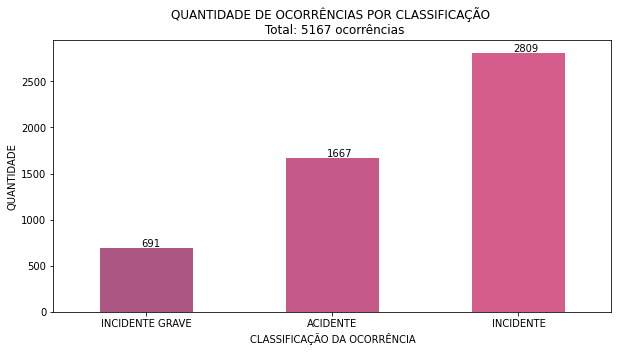

In [13]:
ax_classificacao = df_ocorrencia.groupby('classificacao')['contagem'].sum().sort_values(ascending = True).plot(kind='bar', figsize=(10,5), color=random.choice(colors), alpha=.7)

for p in ax_classificacao.patches:
    b=p.get_bbox()
    ax_classificacao.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.03, b.y1 + 15))

plt.xticks(rotation=0)
plt.xlabel('CLASSIFICAÇÃO DA OCORRÊNCIA')
plt.ylabel('QUANTIDADE')
plt.title('QUANTIDADE DE OCORRÊNCIAS POR CLASSIFICAÇÃO \n Total: ' + str(df_ocorrencia['contagem'].sum()) + ' ocorrências')
plt.show()

As ocorrências são classificadas em: ACIDENTE, INCIDENTE e INDICENTE GRAVE

De acordo com os dados desse plot, as maiores ocorrências foram classificadas como INCIDENTE, representando quase 55% das ocorrências.

<b> Como tem sido a progressão das ocorrências considerando o intervalo de tempo disponível? </b>


dia
2012    647
2013    654
2014    569
2015    471
2016    403
2017    433
2018    444
2019    496
2020    509
2021    541
Name: contagem, dtype: int64


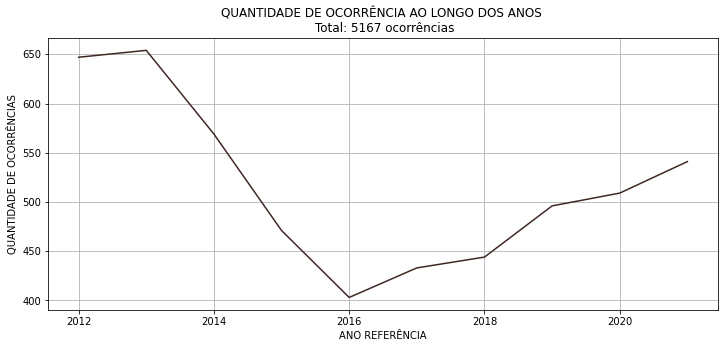

In [14]:
plotagem_data = df_ocorrencia.copy()
plotagem_data['dia'] = plotagem_data['dia'].apply(lambda x: x.replace(x,x[-4:]))
print(plotagem_data.groupby('dia')['contagem'].sum())
plotagem_data.groupby('dia')['contagem'].sum().plot(color=random.choice(colors), figsize=(12,5), grid=True)

plt.title('QUANTIDADE DE OCORRÊNCIA AO LONGO DOS ANOS \n Total: ' + str(df_ocorrencia['contagem'].sum()) + ' ocorrências')
plt.xlabel('ANO REFERÊNCIA')
plt.ylabel('QUANTIDADE DE OCORRÊNCIAS')
plt.show()

O maior número de ocorrências (654) foi no ano de 2013. Depois desse pico, o número de ocorrências começou a diminuir tendo atingido seu valor mínimo (403) em 2016. Nos anos seguintes, infelizmente o número de ocorrências voltou a crescer a cada ano.

<b> Em relação ao local onde aconteceram as ocorrências, quais foram os estados que mais registraram ocorrências? </b>

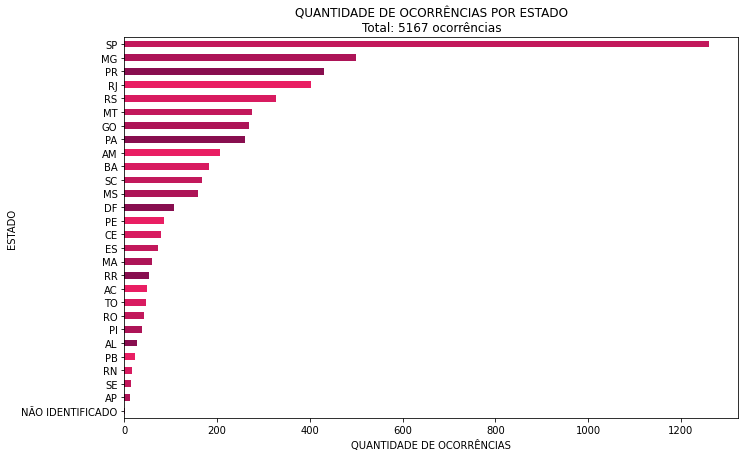

In [15]:
df_ocorrencia.groupby('uf')['contagem'].sum().sort_values(ascending = True).plot(kind='barh', color=random.choice(colors), figsize=(11,7))

plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('ESTADO')
plt.title('QUANTIDADE DE OCORRÊNCIAS POR ESTADO\nTotal: ' + str(df_ocorrencia['contagem'].sum()) + ' ocorrências')
plt.xticks(rotation=0)
plt.show()

In [16]:
ocorrencia_uf = df_ocorrencia.groupby('uf')['contagem'].sum()
ocorrencias_norte = ocorrencia_uf['AC'] + ocorrencia_uf['AM'] + ocorrencia_uf['AP'] + ocorrencia_uf['PA'] + ocorrencia_uf['RO'] + ocorrencia_uf['RR'] + ocorrencia_uf['TO']
ocorrencias_nordeste = ocorrencia_uf['AL'] + ocorrencia_uf['BA'] + ocorrencia_uf['CE'] + ocorrencia_uf['MA'] + ocorrencia_uf['PB'] + ocorrencia_uf['PE'] + ocorrencia_uf['PI'] + ocorrencia_uf['RN'] + ocorrencia_uf['SE']
ocorrencias_centrooeste = ocorrencia_uf['DF'] + ocorrencia_uf['GO'] + ocorrencia_uf['MS'] + ocorrencia_uf['MT']
ocorrencias_sul = ocorrencia_uf['PR'] + ocorrencia_uf['RS'] + ocorrencia_uf['SC']

print('São paulo : ', ocorrencia_uf['SP'])
print('Norte : ', ocorrencias_norte)
print('Nordeste : ', ocorrencias_nordeste)
print('Centro-oeste : ', ocorrencias_centrooeste)
print('Sul : ', ocorrencias_sul)

São paulo :  1261
Norte :  672
Nordeste :  525
Centro-oeste :  808
Sul :  925


O Estado de São Paulo foi aquele que que apresentou mais ocorrências. 

Apenas o Estado de São Paulo apresentou mais ocorrências que qualquer uma das outras regiões do país (considerando o somatório das ocorrências dos estados individualmente).

Algumas ocorrencias estão com Estado de ocorrencia definido como 'NÃO IDENTIFICADO'. Esse valor é decorrente de ocorrencias classificadas como ACIDENTES que ocorreram em águas internacionais (como pode ser visto abaixo).

In [17]:
#Duas ocorrências em que não tiveram locais determinados
df_ocorrencia[df_ocorrencia['uf'] == 'NÃO IDENTIFICADO']

,codigo_ocorrencia,ocorrencia_tipo,ocorrencia_aeronave,ocorrencia_fator,ocorrencia_recomendação,classificacao,cidade,uf,pais,dia,investigacao_status,contagem
1099,49474,49474,49474,49474,49474,ACIDENTE,ÁGUAS INTERNACIONAIS,NÃO IDENTIFICADO,BRASIL,02/09/2013,FINALIZADA,1
4728,79956,79956,79956,79956,79956,ACIDENTE,NÃO IDENTIFICADA,NÃO IDENTIFICADO,BRASIL,26/02/2021,ATIVA,1


<b> Como estão distribuídas pelos Estados cada uma das classificações de ocorrência? </b>

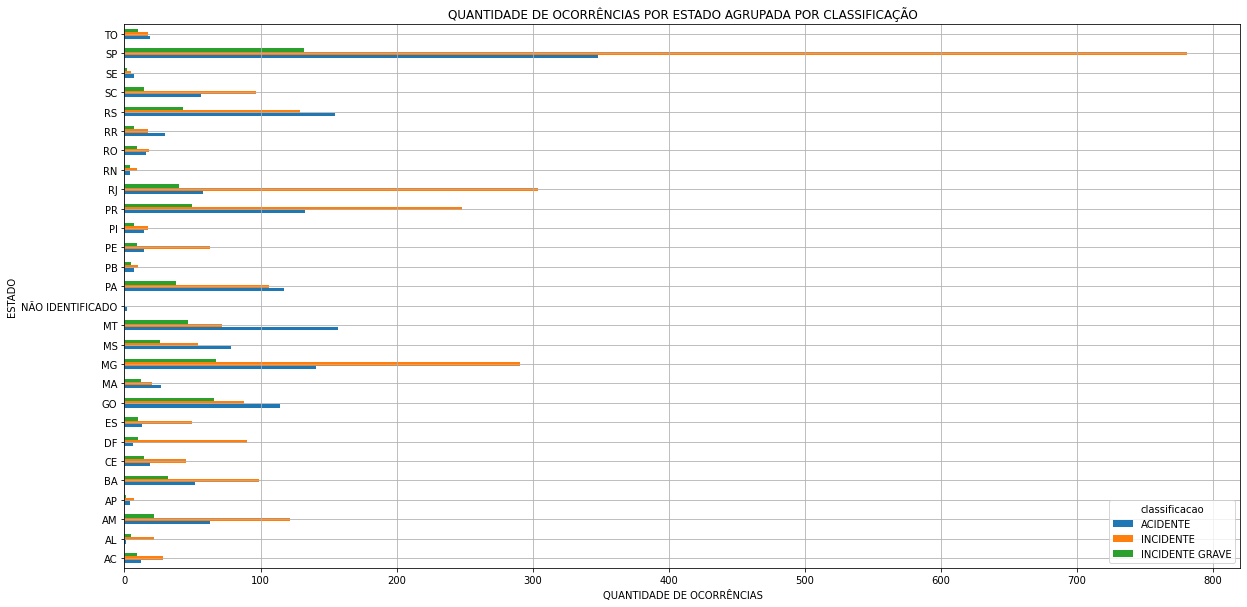

In [18]:
# plotar gráfico estratificado
df_ocorrencia.groupby(['uf']).classificacao.value_counts().unstack().plot(kind='barh', figsize=(20,10), grid = True)
plt.title('QUANTIDADE DE OCORRÊNCIAS POR ESTADO AGRUPADA POR CLASSIFICAÇÃO')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('ESTADO')
plt.show()

São Paulo continua apresentando piores resultados para as três classificações

<h1> Aeronaves </h1>

O processo para a realização da limpeza dos dados é semelhante ao que foi realizado na tabela de ocorrências. Ou seja,
<br> - Colunas foram descartadas
<br> - As entradas contendo o texto *** são substituidas por 'NÃO IDENTIFICADO'
<br> - Por fim, foi incluida uma nova coluna denominada 'contagem' para ser utilizada nos cálculos.

<h3> Limpeza dos Dados (Data Cleaning) </h3>

In [19]:
aeronave.head()

,codigo_ocorrencia2,aeronave_matricula,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,...,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total
0,45331,PRTKB,***,AVIÃO,AEROSPATIALE AND ALENIA,ATR-42-500,AT45,TURBOÉLICE,BIMOTOR,18600,...,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,DESCIDA,REGULAR,NENHUM,0
1,45332,PTUDD,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201A,IPAN,PISTÃO,MONOMOTOR,1800,...,BRASIL,BRASIL,AVIÃO,ESPECIALIZADA,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,AGRÍCOLA,SUBSTANCIAL,0
2,45333,PTGOO,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201,IPAN,PISTÃO,MONOMOTOR,1800,...,BRASIL,BRASIL,AVIÃO,ESPECIALIZADA,FORA DE AERODROMO,FORA DE AERODROMO,ESPECIALIZADA,AGRÍCOLA,SUBSTANCIAL,0
3,45334,PRMHX,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A320-214,A320,JATO,BIMOTOR,77000,...,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,CORRIDA APÓS POUSO,REGULAR,LEVE,0
4,45390,PTUEW,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201A,IPAN,PISTÃO,MONOMOTOR,1800,...,BRASIL,BRASIL,AVIÃO,AGRÍCOLA,FORA DE AERODROMO,FORA DE AERODROMO,ESPECIALIZADA,AGRÍCOLA,SUBSTANCIAL,0


In [20]:
aeronave.dtypes

codigo_ocorrencia2               int64
aeronave_matricula              object
aeronave_operador_categoria     object
aeronave_tipo_veiculo           object
aeronave_fabricante             object
aeronave_modelo                 object
aeronave_tipo_icao              object
aeronave_motor_tipo             object
aeronave_motor_quantidade       object
aeronave_pmd                     int64
aeronave_pmd_categoria           int64
aeronave_assentos              float64
aeronave_ano_fabricacao        float64
aeronave_pais_fabricante        object
aeronave_pais_registro          object
aeronave_registro_categoria     object
aeronave_registro_segmento      object
aeronave_voo_origem             object
aeronave_voo_destino            object
aeronave_fase_operacao          object
aeronave_tipo_operacao          object
aeronave_nivel_dano             object
aeronave_fatalidades_total       int64
dtype: object

In [21]:
df_aeronave = aeronave.drop(['aeronave_matricula','aeronave_operador_categoria','aeronave_tipo_icao', 'aeronave_pmd', 'aeronave_pmd_categoria',
               'aeronave_voo_origem', 'aeronave_pais_fabricante', 'aeronave_registro_categoria',
               'aeronave_registro_segmento', 'aeronave_voo_origem', 'aeronave_voo_destino'], axis = 1, inplace = False)

df_aeronave.head()

,codigo_ocorrencia2,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_registro,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total
0,45331,AVIÃO,AEROSPATIALE AND ALENIA,ATR-42-500,TURBOÉLICE,BIMOTOR,50.0,2001.0,BRASIL,DESCIDA,REGULAR,NENHUM,0
1,45332,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201A,PISTÃO,MONOMOTOR,1.0,1987.0,BRASIL,DECOLAGEM,AGRÍCOLA,SUBSTANCIAL,0
2,45333,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201,PISTÃO,MONOMOTOR,1.0,1976.0,BRASIL,ESPECIALIZADA,AGRÍCOLA,SUBSTANCIAL,0
3,45334,AVIÃO,AIRBUS INDUSTRIE,A320-214,JATO,BIMOTOR,184.0,2008.0,BRASIL,CORRIDA APÓS POUSO,REGULAR,LEVE,0
4,45390,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201A,PISTÃO,MONOMOTOR,1.0,1989.0,BRASIL,ESPECIALIZADA,AGRÍCOLA,SUBSTANCIAL,0


In [22]:
df_aeronave.columns = ['ocorrencia_aeronave','tipo_veiculo','fabricante','modelo','motor_tipo','motor_quantidade',
                    'assentos','ano_fabricacao','pais_registro','fase_operacao','tipo_operacao',
                    'nivel_dano','fatalidades_total']
df_aeronave = df_aeronave.apply(lambda x: x.replace('***','NÃO IDENTIFICADO'))
df_aeronave['contagem'] = 1

In [23]:
#DataFrame alterado
df_aeronave.head()

,ocorrencia_aeronave,tipo_veiculo,fabricante,modelo,motor_tipo,motor_quantidade,assentos,ano_fabricacao,pais_registro,fase_operacao,tipo_operacao,nivel_dano,fatalidades_total,contagem
0,45331,AVIÃO,AEROSPATIALE AND ALENIA,ATR-42-500,TURBOÉLICE,BIMOTOR,50.0,2001.0,BRASIL,DESCIDA,REGULAR,NENHUM,0,1
1,45332,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201A,PISTÃO,MONOMOTOR,1.0,1987.0,BRASIL,DECOLAGEM,AGRÍCOLA,SUBSTANCIAL,0,1
2,45333,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201,PISTÃO,MONOMOTOR,1.0,1976.0,BRASIL,ESPECIALIZADA,AGRÍCOLA,SUBSTANCIAL,0,1
3,45334,AVIÃO,AIRBUS INDUSTRIE,A320-214,JATO,BIMOTOR,184.0,2008.0,BRASIL,CORRIDA APÓS POUSO,REGULAR,LEVE,0,1
4,45390,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201A,PISTÃO,MONOMOTOR,1.0,1989.0,BRASIL,ESPECIALIZADA,AGRÍCOLA,SUBSTANCIAL,0,1


Duas ações de pré-processamento a mais que serão realizadas na tabela de aeronave são: 
<br> Preenchimento de valores nulos nas linhas com o numemral 0 
<br> Converter as colunas que estão definidas como float para int. Não faz sentido ter tratar 'fatalidades_total','ano_fabricacao','assentos' como valores flutuantes.

In [24]:
convert_na(df_aeronave,['fatalidades_total','ano_fabricacao','assentos'])
convert_dtype(df_aeronave,['assentos','ano_fabricacao','fatalidades_total'],int)

In [25]:
#DataFrame alterado
df_aeronave.head()

,ocorrencia_aeronave,tipo_veiculo,fabricante,modelo,motor_tipo,motor_quantidade,assentos,ano_fabricacao,pais_registro,fase_operacao,tipo_operacao,nivel_dano,fatalidades_total,contagem
0,45331,AVIÃO,AEROSPATIALE AND ALENIA,ATR-42-500,TURBOÉLICE,BIMOTOR,50,2001,BRASIL,DESCIDA,REGULAR,NENHUM,0,1
1,45332,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201A,PISTÃO,MONOMOTOR,1,1987,BRASIL,DECOLAGEM,AGRÍCOLA,SUBSTANCIAL,0,1
2,45333,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201,PISTÃO,MONOMOTOR,1,1976,BRASIL,ESPECIALIZADA,AGRÍCOLA,SUBSTANCIAL,0,1
3,45334,AVIÃO,AIRBUS INDUSTRIE,A320-214,JATO,BIMOTOR,184,2008,BRASIL,CORRIDA APÓS POUSO,REGULAR,LEVE,0,1
4,45390,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-201A,PISTÃO,MONOMOTOR,1,1989,BRASIL,ESPECIALIZADA,AGRÍCOLA,SUBSTANCIAL,0,1


In [26]:
# #Verificando se os dataframes são iguais
# df_aeronave['ocorrencia_aeronave'].equals(df_ocorrencia['ocorrencia_aeronave'])

In [27]:
# #Pegando linhas duplicadas no DataFrame
# df_ocorrencias_duplicadas = df_aeronave[df_aeronave['ocorrencia_aeronave'].duplicated()].reset_index(drop=True)
# df_ocorrencias_duplicadas.drop('contagem', axis = 1, inplace = True)
# print('Há ' + str(df_ocorrencias_duplicadas.shape[0]) + ' ocorrências duplicadas.')

In [28]:
# df_ocorrencias_duplicadas.head()

<h3> Visualização dos Dados (Data Visualization) </h3>

Após o tratamento e limpeza dos dados, é hora de gerarmos visualizações os dados e realizarmos a análise exploratória dos dados. 
Na tabela aeronave existe a informação sobre o tipo de motor utilizado. Então o seguinte questionamento pode ser realizado:

<b> Qual tipo de motor mais gerou ocorrências? </b>

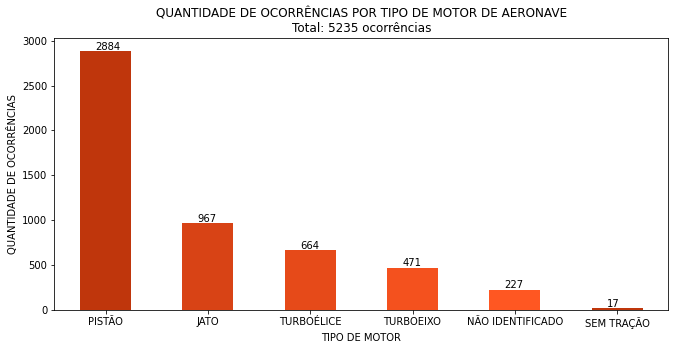

In [29]:
ax = df_aeronave.groupby('motor_tipo')['contagem'].sum().sort_values(ascending = False).plot(kind='bar', color=random.choice(colors), figsize=(11,5))

for p in ax.patches:
    b=p.get_bbox()
    ax.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.1, b.y1 + 15))

plt.title('QUANTIDADE DE OCORRÊNCIAS POR TIPO DE MOTOR DE AERONAVE\nTotal: '+str(df_aeronave['contagem'].sum())+' ocorrências')
plt.ylabel('QUANTIDADE DE OCORRÊNCIAS')
plt.xlabel('TIPO DE MOTOR')
plt.xticks(rotation=0)
plt.show()

Os motores a pistão foram aqueles que resultaram em uma maior quantidade de ocorrências geradas. Vale destacar que apenas esse tipo de motor gerou mais ocorrências que o somatório de todos os demais tipos de motor juntos.

Próxima pergunta:
<b> Será que ocorrências envolvendo aviões aparecem em maior frequência do que para outras aeronaves? </b>

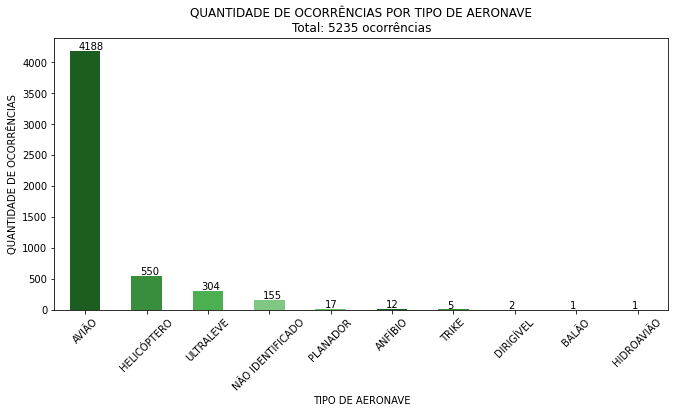

In [30]:
ax = df_aeronave.groupby('tipo_veiculo')['contagem'].sum().sort_values(ascending = False).plot(kind='bar', figsize=(11,5), color=random.choice(colors))

for p in ax.patches:
    b=p.get_bbox()
    ax.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.1, b.y1 + 15))
    
plt.title('QUANTIDADE DE OCORRÊNCIAS POR TIPO DE AERONAVE\nTotal: ' + str(df_aeronave['contagem'].sum()) + ' ocorrências')
plt.ylabel('QUANTIDADE DE OCORRÊNCIAS')
plt.xlabel('TIPO DE AERONAVE')
plt.xticks(rotation=45)
plt.show()

Definitivamente, ocorrências envolvendo aviões surgem com muito mais frequência do que para qualquer outro tipo de aeronava. Assim como na análise anterior, a quantidade total de ocorrências de aviões é maior do que a soma de todos os outros tipos de aeronave.

Dando continuidade:
<b> Quais são as fabricantes que mais aparecem nos problemas relatados? </b>


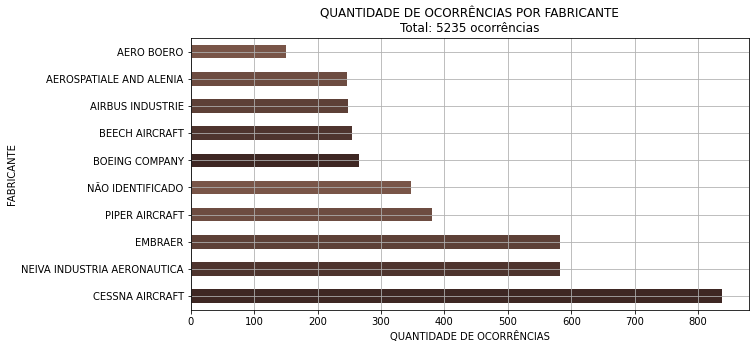

In [31]:
ocorrencias_fabricante = df_aeronave.groupby('fabricante')['contagem'].sum().sort_values(ascending = False)
ocorrencias_fabricante.head(10).plot(kind='barh', figsize=(10,5), color=random.choice(colors), grid=True)

plt.title('QUANTIDADE DE OCORRÊNCIAS POR FABRICANTE\nTotal: ' + str(df_aeronave['contagem'].sum()) + ' ocorrências')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('FABRICANTE')
plt.show()

A fabricante Cessna Aircraft foi aquela que apresentou mais ocorrências, seguida da Neiva Industria Aeronautica e da Embrae.

Um outro questionamento:

<b> Viagens comerciais regulares tendem a ter mais problemas do que voos privados? </b>


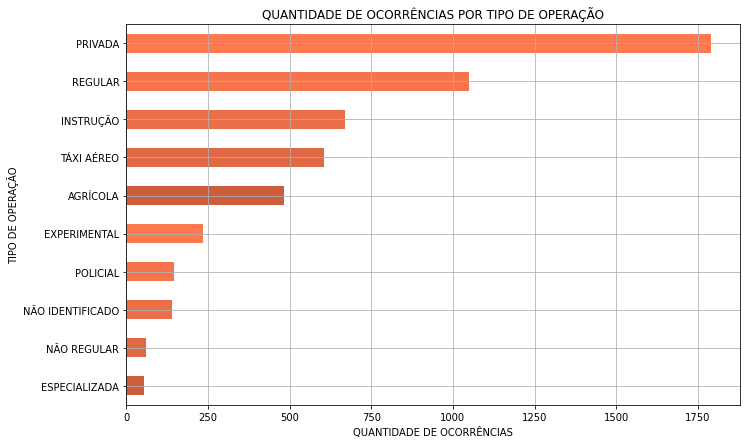

In [32]:
categoria_aviao = df_aeronave.groupby('tipo_operacao')['contagem'].sum().sort_values().plot(kind='barh', figsize=(11,7), color=random.choice(colors), alpha=.8, grid = True)

plt.title('QUANTIDADE DE OCORRÊNCIAS POR TIPO DE OPERAÇÃO')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('TIPO DE OPERAÇÃO')
plt.show()


A resposta para essa pergunta é <b>não</b>. Como pode ser observado a quantidade de ocorrências em vôos privados é maior quando comparados a vôos regulares.

Agora vamos analisar o momento em que as ocorrências surgiram. 
<b> Qual o momento da viagem que houve mais ocorrências vinculadas? </b>


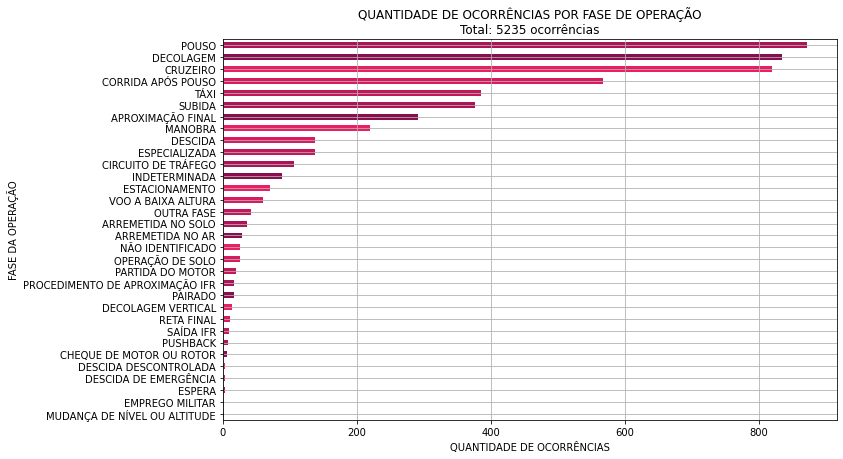

In [33]:
fase_de_operacao = df_aeronave.groupby('fase_operacao')['contagem'].sum().sort_values().plot(kind='barh', figsize=(11,7), color=random.choice(colors), grid = True)
plt.title('QUANTIDADE DE OCORRÊNCIAS POR FASE DE OPERAÇÃO\nTotal: ' + str(df_aeronave['contagem'].sum()) + ' ocorrências')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('FASE DA OPERAÇÃO')
plt.show()

O momento do pouso foi o que gerou mais ocorrências, seguido da decolagem e do cruzeiro (momento da viagem em si). Não houve uma diferença significativa entre esses três momentos.

Nem toda ocorrência gerada resulta em danos na aeronave. Sobre isso <b>quais são os tipos de danos que podem ocorrer a uma aeronave? Qual a frequência?</b>


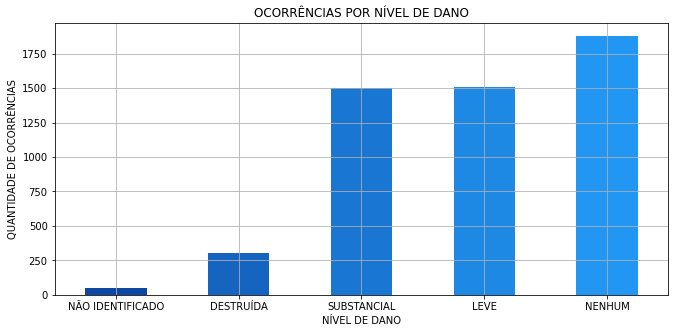

In [34]:
tipo_de_dano = df_aeronave.groupby('nivel_dano')['contagem'].sum().sort_values().plot(kind='bar', figsize=(11,5), color=random.choice(colors), grid = True)

plt.title('OCORRÊNCIAS POR NÍVEL DE DANO')
plt.ylabel('QUANTIDADE DE OCORRÊNCIAS')
plt.xlabel('NÍVEL DE DANO')
plt.xticks(rotation=0)
plt.show()

De forma impressionante, a maior parte das ocorrências não resultou em dano nenhum nas aeronaves.

Da mesma forma, nem toda ocorrência gerada resulta em fatalidades.
<b> Qual o numero de fatalidades que aconteceram com maior frequencia? </b>


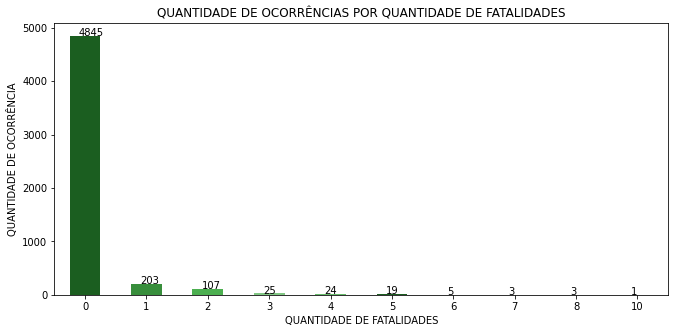

In [35]:
ax_fatalidades = df_aeronave.groupby('fatalidades_total')['contagem'].sum().plot(kind='bar', figsize=(11,5), color=random.choice(colors))

for p in ax_fatalidades.patches:
    b=p.get_bbox()
    ax_fatalidades.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.1, b.y1 + 2))
    
plt.title('QUANTIDADE DE OCORRÊNCIAS POR QUANTIDADE DE FATALIDADES')
plt.xlabel('QUANTIDADE DE FATALIDADES')
plt.ylabel('QUANTIDADE DE OCORRÊNCIA')
plt.xticks(rotation=0)
plt.show()

In [36]:
# fatalidades_maior_que_zero = df_aeronave[df_aeronave['fatalidades_total'] > 0]
# fatalidades = fatalidades_maior_que_zero.groupby('fatalidades_total')['contagem'].sum().plot(kind='bar', figsize=(11,5), color=random.choice(colors))

# for p in fatalidades.patches:
#     b=p.get_bbox()
#     fatalidades.annotate("{:.0f}".format(b.y1 + b.y0), ((b.x0 + b.x1)/2 - 0.1, b.y1 + 2))
    
# plt.title('QUANTIDADE DE OCORRÊNCIAS DOS ÚLTIMOS 10 ANOS AGRUPADAS\nPOR QUANTIDADE DE FATALIDADES')
# plt.xlabel('QUANTIDADE DE FATALIDADES')
# plt.ylabel('QUANTIDADE DE OCORRÊNCIA')
# plt.xticks(rotation=0)
# plt.show()

Felizmente, casos em que não houveram fatalidades foi a grande maioria.

<h3> Cruzamento de dados </h3>

Aqui será feito o cruzamento de dados entre as tabelas ocorrencia e aeronave. 

O objetivo é realizar a análise dos atributos presentes na tabela aeronave agrupadas pelo atributo classificacao da tabela ocorrencia

In [37]:
temp_ocorrencia = df_ocorrencia.drop(['contagem'], axis = 1, inplace = False)
temp_aeronave = df_aeronave.drop(['contagem'], axis = 1, inplace = False)

In [38]:
df_ocorrencia_aeronave = pd.merge(temp_ocorrencia, temp_aeronave, on='ocorrencia_aeronave', how='left')

<b> Qual o reflexo do tipo de motor em cada uma das classificações? </b>

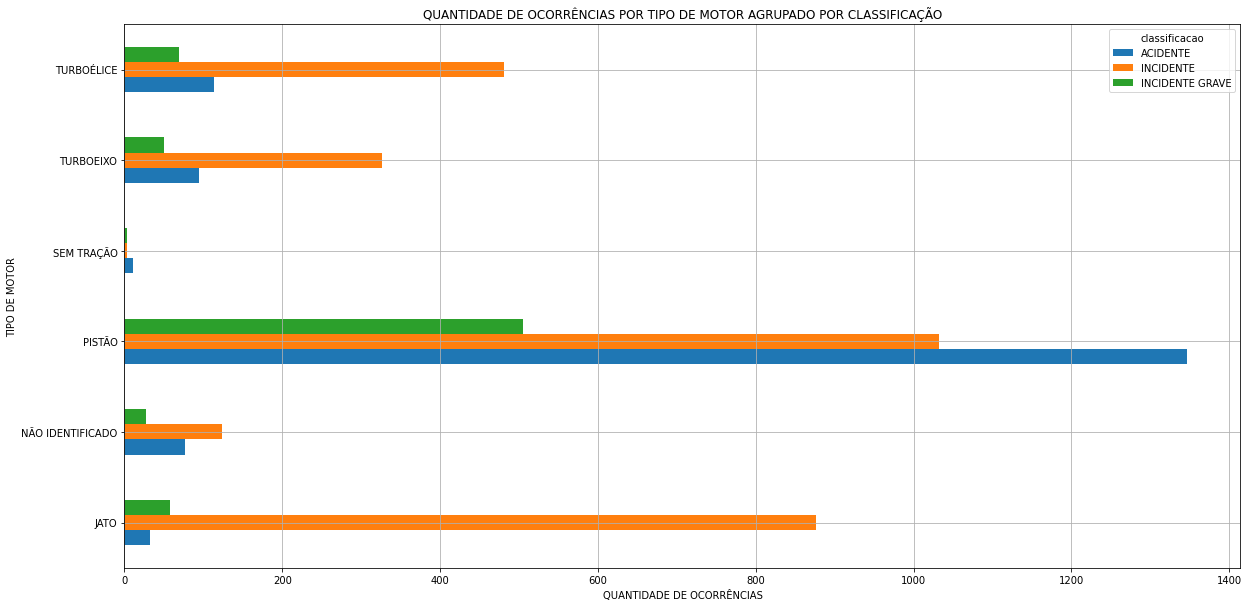

In [39]:
df_ocorrencia_aeronave.groupby(['motor_tipo']).classificacao.value_counts().unstack().plot(kind='barh', figsize=(20,10), grid = True)
plt.title('QUANTIDADE DE OCORRÊNCIAS POR TIPO DE MOTOR AGRUPADO POR CLASSIFICAÇÃO')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('TIPO DE MOTOR')
plt.show()

Já se sabe que os motores a pistão foram aqueles que resultaram em uma maior quantidade de ocorrências geradas. No entanto, ao fazer a análise considerando o agrupamento por classificação, pode-se perceber um comportamento interessante. Para o caso do pistão, o comportamento da distribuição da classificação muda:

Aciente: 33% -> 46%

Incidente: 55% -> 36%

Incidente Grave: 12% -> 18%

A porcentagem de ocorrencias com pistão que resultam em Acidente ou Incidente grave são percentualmente maiores do que o comportamento padrão. Ou seja, ocorrencias resultantes de pistão são mais graves.

<b> Qual a frequência dos tipos de danos por classificação de ocorrência? </b>

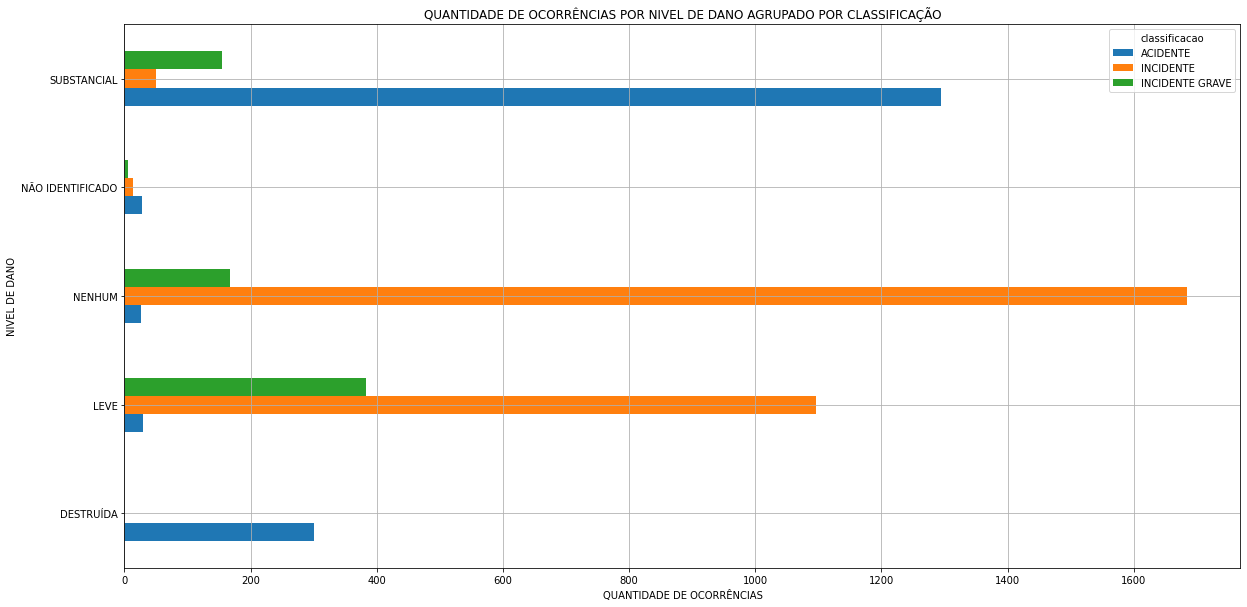

In [40]:
df_ocorrencia_aeronave.groupby(['nivel_dano']).classificacao.value_counts().unstack().plot(kind='barh', figsize=(20,10), grid = True)
plt.title('QUANTIDADE DE OCORRÊNCIAS POR NIVEL DE DANO AGRUPADO POR CLASSIFICAÇÃO')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('NIVEL DE DANO')
plt.show()

ACIDENTES estão relacionados a maiores estragos (substancial ou destruido)

<b> Qual a frequência de fatalidades por classificação de ocorrência? </b>

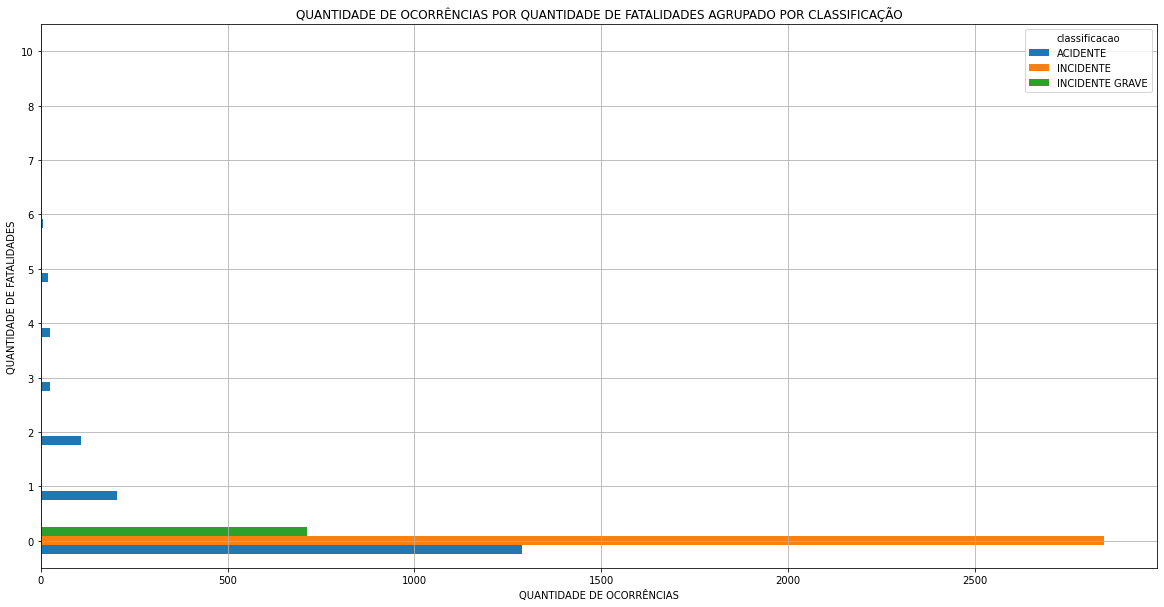

In [41]:
df_ocorrencia_aeronave.groupby(['fatalidades_total']).classificacao.value_counts().unstack().plot(kind='barh', figsize=(20,10), grid = True)
plt.title('QUANTIDADE DE OCORRÊNCIAS POR QUANTIDADE DE FATALIDADES AGRUPADO POR CLASSIFICAÇÃO')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('QUANTIDADE DE FATALIDADES')
plt.show()

INCIDENTES e INCIDENTES GRAVES não resultaram em nenhuma fatalidade

<b> Como se distribuem as ocorrências por tipo de aeronave em cada classificação? </b>

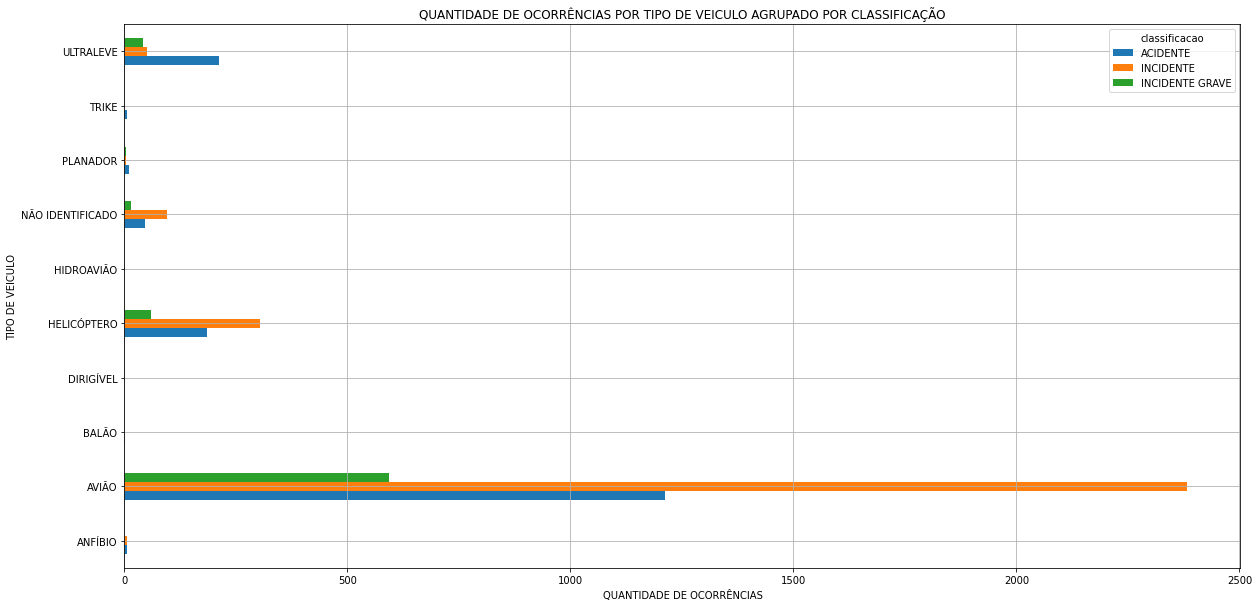

In [42]:
df_ocorrencia_aeronave.groupby(['tipo_veiculo']).classificacao.value_counts().unstack().plot(kind='barh', figsize=(20,10), grid = True)
plt.title('QUANTIDADE DE OCORRÊNCIAS POR TIPO DE VEICULO AGRUPADO POR CLASSIFICAÇÃO')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('TIPO DE VEICULO')
plt.show()

Como já se sabe, o maior número de ocorrências está relacionado ao tipo avião - 80%. Pode ser observado que para as ocorrencias de avião, a distribuição se mantém, isto é, mais INCIDENTES, depois ACIDENTES e por ultimo INCIDENTES GRAVES.

No entanto, pode-se ser destacado uma mudança no comportamento dentro de ultraleve, em que a maior ocorrência é de ACIDENTES. Então ocorrencias em ultraleves tendem a serem mais graves do que os de avião


<h1> Tipo de ocorrencia </h1>

O processo para a realização da limpeza dos dados é semelhante ao que foi realizado na tabela de ocorrências. Ou seja,
<br> - Colunas foram descartadas
<br> - As entradas contendo o texto *** são substituidas por 'NÃO IDENTIFICADO'
<br> - Por fim, foi incluida uma nova coluna denominada 'contagem' para ser utilizada nos cálculos.

<h3> Limpeza de Dados (Data Cleaning) </h3>

In [43]:
tipo.head()

,codigo_ocorrencia1,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao
0,45331,COM PESSOAL EM VOO,OUTROS | COM PESSOAL EM VOO,OTHR
1,45332,PERDA DE CONTROLE NO SOLO,PERDA DE CONTROLE NO SOLO,LOC-G
2,45333,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR | FALHA DO...,SCF-PP
3,45334,ESTOURO DE PNEU,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
4,45390,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,LALT


In [44]:
tipo.dtypes

codigo_ocorrencia1            int64
ocorrencia_tipo              object
ocorrencia_tipo_categoria    object
taxonomia_tipo_icao          object
dtype: object

In [45]:
df_tipo = tipo.drop(['taxonomia_tipo_icao'], axis = 1, inplace = False)

In [46]:
df_tipo.columns = ['ocorrencia_tipo', 'tipo', 'categoria']
df_tipo = df_tipo.apply(lambda x: x.replace('***','NÃO IDENTIFICADO'))
df_tipo['contagem'] = 1

In [47]:
df_tipo.head()

,ocorrencia_tipo,tipo,categoria,contagem
0,45331,COM PESSOAL EM VOO,OUTROS | COM PESSOAL EM VOO,1
1,45332,PERDA DE CONTROLE NO SOLO,PERDA DE CONTROLE NO SOLO,1
2,45333,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR | FALHA DO...,1
3,45334,ESTOURO DE PNEU,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,1
4,45390,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,1


<h3> Visualização dos Dados (Data Visualization) </h3>

Após o tratamento e limpeza dos dados, é hora de gerarmos visualizações os dados e realizarmos a análise exploratória dos dados. 
Na tabela aeronave existe a informação sobre o tipo de motor utilizado. Então o seguinte questionamento pode ser realizado:

<b> Qual categoria e tipo de ocorrência resultaram em mais ocorrencias? </b>

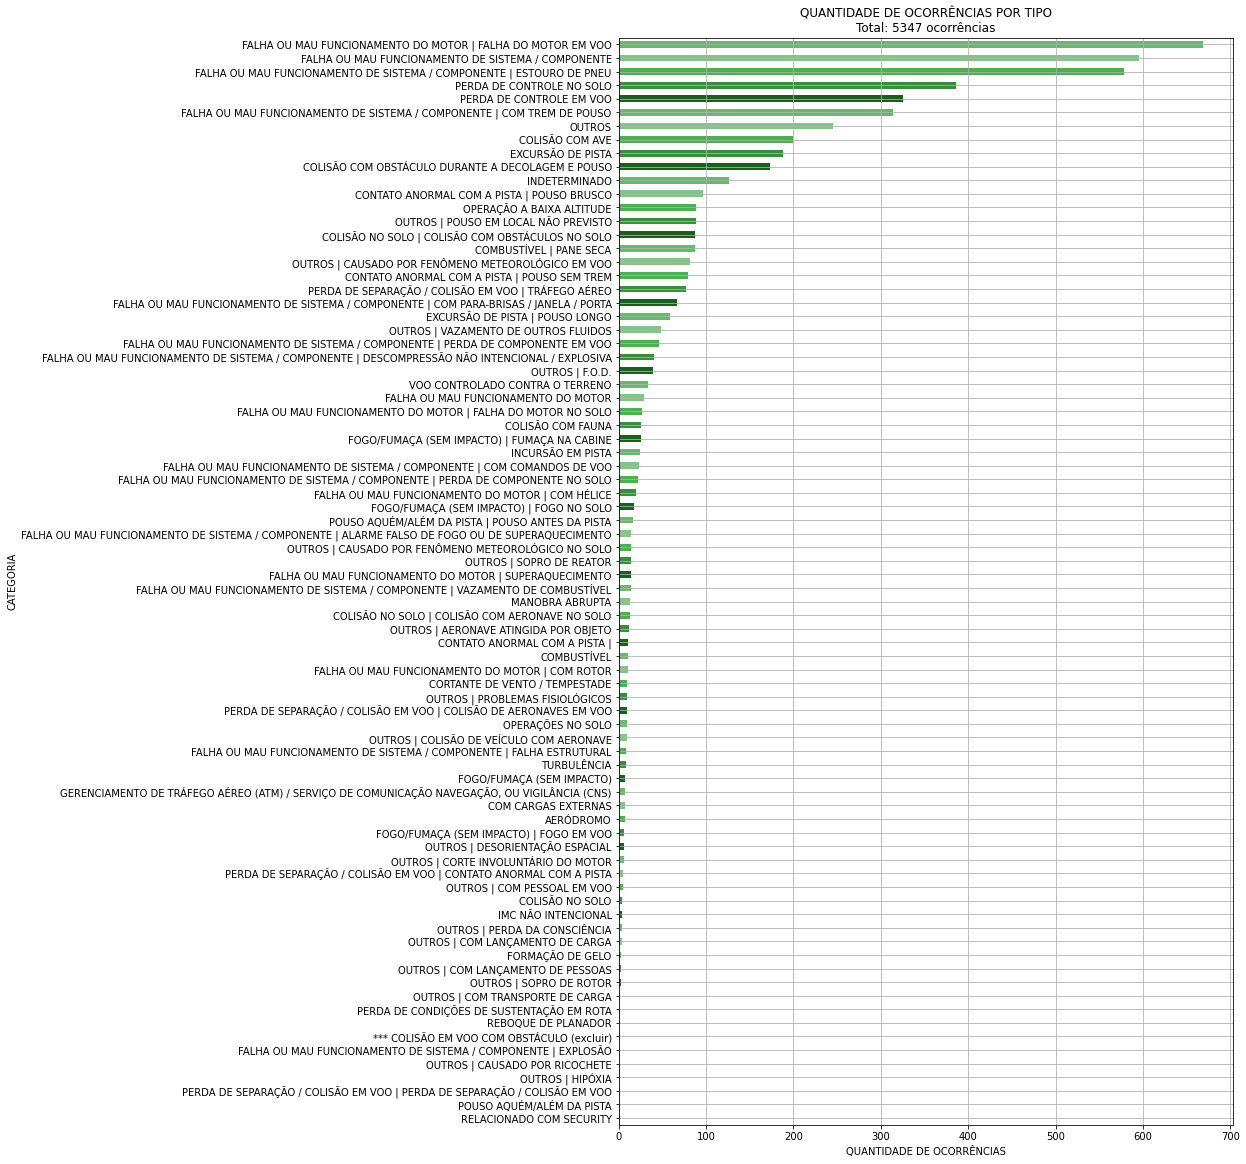

In [48]:
df_tipo.groupby('categoria')['contagem'].sum().sort_values().plot(kind='barh', figsize=(11,20), color=random.choice(colors), grid = True)
plt.title('QUANTIDADE DE OCORRÊNCIAS POR TIPO\nTotal: ' + str(df_tipo['contagem'].sum()) + ' ocorrências')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('CATEGORIA')
plt.show()

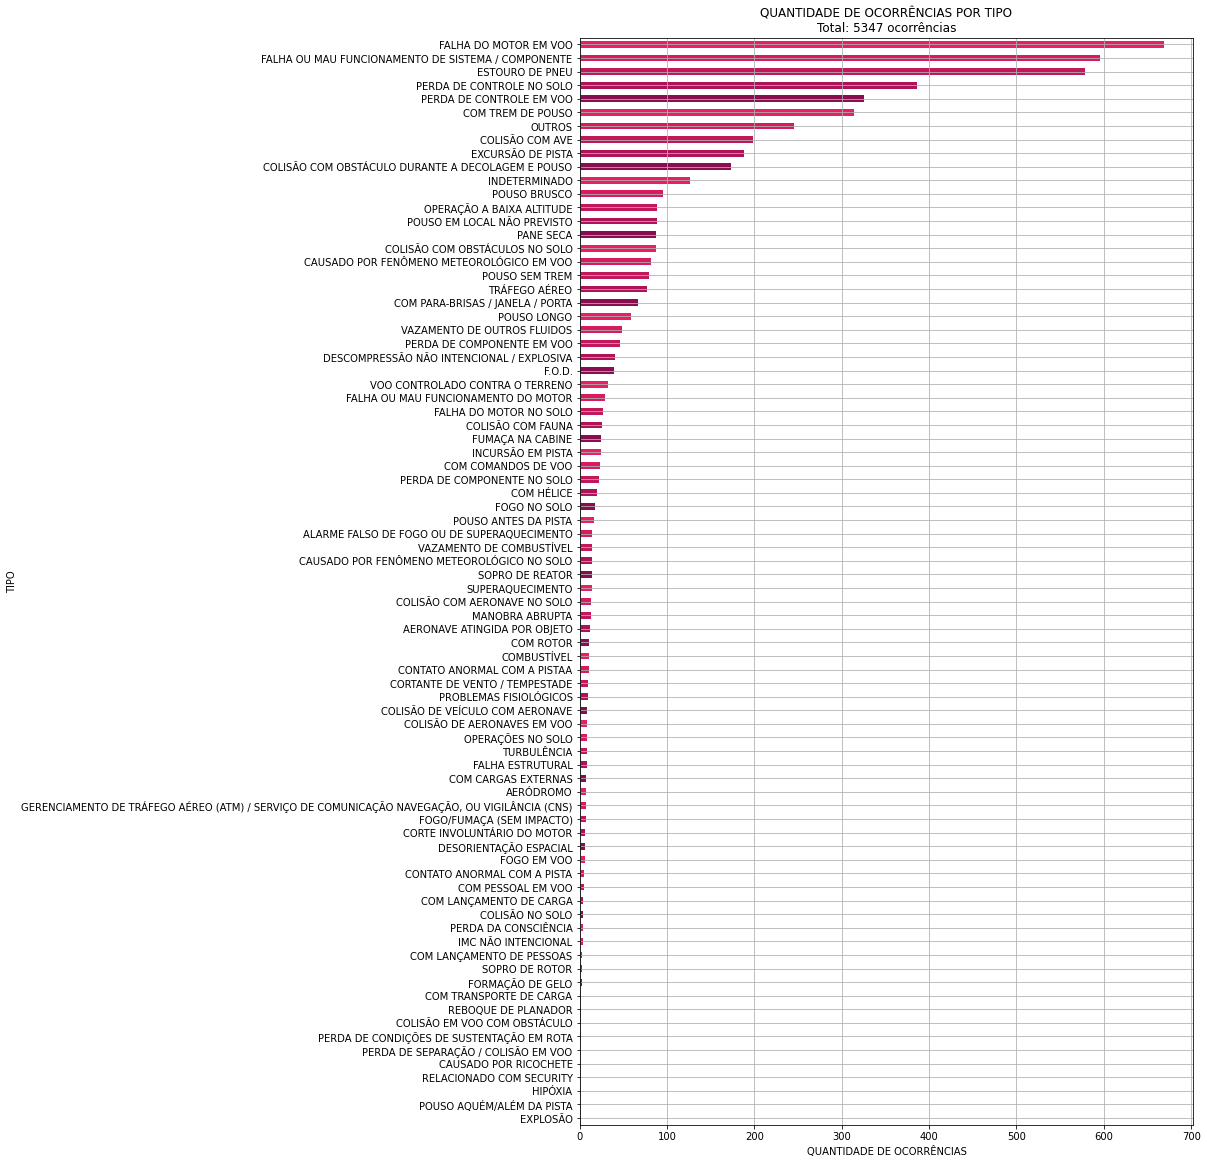

In [49]:
df_tipo.groupby('tipo')['contagem'].sum().sort_values().plot(kind='barh', figsize=(11,20), color=random.choice(colors), grid = True)
plt.title('QUANTIDADE DE OCORRÊNCIAS POR TIPO\nTotal: ' + str(df_tipo['contagem'].sum()) + ' ocorrências')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('TIPO')
plt.show()

Como pode ser observado desses dois plots, Falha no Motor foi aquele que gerou mais ocorrências.

<h1> Fator Contribuinte </h1>

O processo para a realização da limpeza dos dados é semelhante ao que foi realizado na tabela de ocorrências. Ou seja,
<br> - Colunas foram descartadas
<br> - As entradas contendo o texto *** são substituidas por 'NÃO IDENTIFICADO'
<br> - Por fim, foi incluida uma nova coluna denominada 'contagem' para ser utilizada nos cálculos.

In [50]:
fator_contribuinte.head()

,codigo_ocorrencia3,fator_nome,fator_aspecto,fator_condicionante,fator_area
0,45331,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
1,45331,ATENÇÃO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO
2,45331,CAPACITAÇÃO E TREINAMENTO,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO
3,45331,CLIMA ORGANIZACIONAL,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO
4,45331,COMUNICAÇÃO,ASPECTO PSICOLÓGICO,PSICOSSOCIAL,FATOR HUMANO


In [51]:
df_fator = fator_contribuinte.copy()

In [52]:
df_fator.columns = ['ocorrencia_fator', 'nome_fator', 'aspecto', 'condicionante', 'area']
df_fator = df_fator.apply(lambda x: x.replace('***','NÃO IDENTIFICADO'))
df_fator['contagem'] = 1

In [53]:
df_fator.head()

,ocorrencia_fator,nome_fator,aspecto,condicionante,area,contagem
0,45331,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,1
1,45331,ATENÇÃO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO,1
2,45331,CAPACITAÇÃO E TREINAMENTO,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO,1
3,45331,CLIMA ORGANIZACIONAL,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO,1
4,45331,COMUNICAÇÃO,ASPECTO PSICOLÓGICO,PSICOSSOCIAL,FATOR HUMANO,1


In [54]:
df_fator

,ocorrencia_fator,nome_fator,aspecto,condicionante,area,contagem
0,45331,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,1
1,45331,ATENÇÃO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO,1
2,45331,CAPACITAÇÃO E TREINAMENTO,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO,1
3,45331,CLIMA ORGANIZACIONAL,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO,1
4,45331,COMUNICAÇÃO,ASPECTO PSICOLÓGICO,PSICOSSOCIAL,FATOR HUMANO,1
...,...,...,...,...,...,...
3459,79713,SUPERVISÃO GERENCIAL,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,1
3460,79729,OUTRO FATOR,OUTRO,NÃO IDENTIFICADO,OUTRO,1
3461,80073,MANUTENÇÃO DA AERONAVE,DESEMPENHO DO SER HUMANO,MANUTENÇÃO DA AERONAVE,FATOR OPERACIONAL,1
3462,80258,INFRAESTRUTURA AEROPORTUÁRIA,INFRAESTRUTURA AEROPORTUÁRIA,NÃO IDENTIFICADO,FATOR OPERACIONAL,1


<h3> Visualização dos Dados (Data Visualization) </h3>

Após o tratamento e limpeza dos dados, é hora de gerarmos visualizações os dados e realizarmos a análise exploratória dos dados. 
Na tabela aeronave existe a informação sobre o tipo de motor utilizado. Então o seguinte questionamento pode ser realizado:

<b> Qual aspecto que mais gerou ocorrencias? </b>

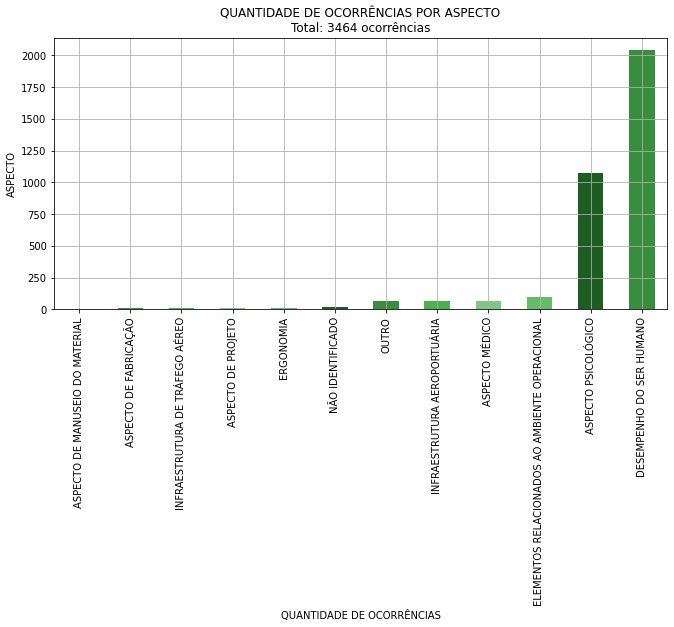

In [55]:
# ['ocorrencia_fator', 'nome_fator', 'aspecto', 'condicionante', 'area']
df_fator.groupby('aspecto')['contagem'].sum().sort_values().plot(kind='bar', figsize=(11,5), color=random.choice(colors), grid = True)
plt.title('QUANTIDADE DE OCORRÊNCIAS POR ASPECTO\nTotal: ' + str(df_fator['contagem'].sum()) + ' ocorrências')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('ASPECTO')
plt.show()

Quase 60% das ocorrências derivaram de desempenho do ser humano.

<b> As ocorrências derivaram mais de fatores humanos ou operacionais? </b>

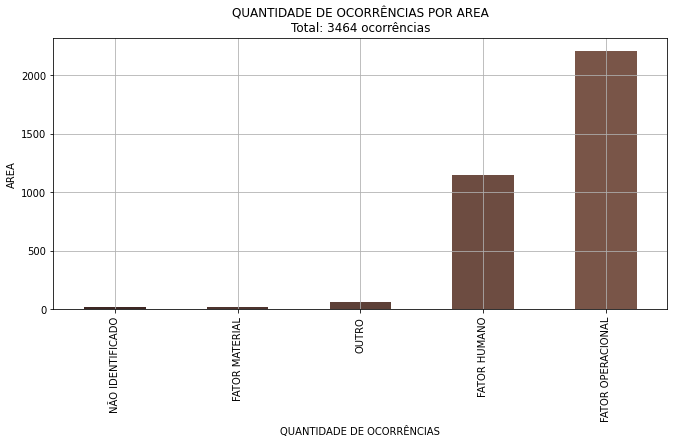

In [56]:
# ['ocorrencia_fator', 'nome_fator', 'aspecto', 'condicionante', 'area']
df_fator.groupby('area')['contagem'].sum().sort_values().plot(kind='bar', figsize=(11,5), color=random.choice(colors), grid = True)
plt.title('QUANTIDADE DE OCORRÊNCIAS POR AREA\nTotal: ' + str(df_fator['contagem'].sum()) + ' ocorrências')
plt.xlabel('QUANTIDADE DE OCORRÊNCIAS')
plt.ylabel('AREA')
plt.show()

A maior parte das ocorrências derivaram de fatores operacionais

<h3> Cruzamento de dados Ocorrencia e Fator </h3>

In [57]:
df_fator_ocorrencia = pd.merge(df_fator, df_ocorrencia, on='ocorrencia_fator', how='inner')

In [58]:
df_fator_ocorrencia['contagem'] = 1
df_fator_ocorrencia

,ocorrencia_fator,nome_fator,aspecto,condicionante,area,contagem_x,codigo_ocorrencia,ocorrencia_tipo,ocorrencia_aeronave,ocorrencia_recomendação,classificacao,cidade,uf,pais,dia,investigacao_status,contagem_y,contagem
0,45331,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,1,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA,1,1
1,45331,ATENÇÃO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO,1,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA,1,1
2,45331,CAPACITAÇÃO E TREINAMENTO,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO,1,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA,1,1
3,45331,CLIMA ORGANIZACIONAL,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO,1,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA,1,1
4,45331,COMUNICAÇÃO,ASPECTO PSICOLÓGICO,PSICOSSOCIAL,FATOR HUMANO,1,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459,79713,SUPERVISÃO GERENCIAL,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,1,79713,79713,79713,79713,ACIDENTE,SANTA VITÓRIA DO PALMAR,RS,BRASIL,06/12/2020,FINALIZADA,1,1
3460,79729,OUTRO FATOR,OUTRO,NÃO IDENTIFICADO,OUTRO,1,79729,79729,79729,79729,ACIDENTE,TAILÂNDIA,PA,BRASIL,15/12/2020,FINALIZADA,1,1
3461,80073,MANUTENÇÃO DA AERONAVE,DESEMPENHO DO SER HUMANO,MANUTENÇÃO DA AERONAVE,FATOR OPERACIONAL,1,80073,80073,80073,80073,ACIDENTE,ARACAJU,SE,BRASIL,06/05/2021,FINALIZADA,1,1
3462,80258,INFRAESTRUTURA AEROPORTUÁRIA,INFRAESTRUTURA AEROPORTUÁRIA,NÃO IDENTIFICADO,FATOR OPERACIONAL,1,80258,80258,80258,80258,ACIDENTE,TANGARÁ DA SERRA,MT,BRASIL,16/10/2019,FINALIZADA,1,1


In [59]:
df_fator_ocorrencia.groupby(['area', 'classificacao'])['contagem'].sum()

area               classificacao  
FATOR HUMANO       ACIDENTE            968
                   INCIDENTE            10
                   INCIDENTE GRAVE     173
FATOR MATERIAL     ACIDENTE              9
                   INCIDENTE             2
                   INCIDENTE GRAVE      12
FATOR OPERACIONAL  ACIDENTE           1757
                   INCIDENTE            21
                   INCIDENTE GRAVE     431
NÃO IDENTIFICADO   ACIDENTE             13
                   INCIDENTE GRAVE       6
OUTRO              ACIDENTE             55
                   INCIDENTE GRAVE       7
Name: contagem, dtype: int64

In [60]:
df_fator_ocorrencia.groupby(['aspecto', 'classificacao'])['contagem'].sum()

aspecto                                         classificacao  
ASPECTO DE FABRICAÇÃO                           ACIDENTE              5
                                                INCIDENTE             1
                                                INCIDENTE GRAVE       2
ASPECTO DE MANUSEIO DO MATERIAL                 ACIDENTE              2
                                                INCIDENTE GRAVE       3
ASPECTO DE PROJETO                              ACIDENTE              2
                                                INCIDENTE             1
                                                INCIDENTE GRAVE       7
ASPECTO MÉDICO                                  ACIDENTE             58
                                                INCIDENTE GRAVE      11
ASPECTO PSICOLÓGICO                             ACIDENTE            901
                                                INCIDENTE            10
                                                INCIDENTE GRAVE     161


In [61]:
df_fator_ocorrencia.groupby(['classificacao', 'condicionante'])['contagem'].sum()

classificacao    condicionante                         
ACIDENTE         INDIVIDUAL                                 571
                 MANUTENÇÃO DA AERONAVE                     155
                 NÃO IDENTIFICADO                           272
                 OPERAÇÃO DA AERONAVE                      1470
                 ORGANIZACIONAL                             249
                 PRESTAÇÃO DE SERVIÇOS DE TRÁFEGO AÉREO       4
                 PSICOSSOCIAL                                81
INCIDENTE        INDIVIDUAL                                   3
                 MANUTENÇÃO DA AERONAVE                       1
                 NÃO IDENTIFICADO                             8
                 OPERAÇÃO DA AERONAVE                         8
                 ORGANIZACIONAL                               5
                 PRESTAÇÃO DE SERVIÇOS DE TRÁFEGO AÉREO       6
                 PSICOSSOCIAL                                 2
INCIDENTE GRAVE  INDIVIDUAL                     

In [62]:
df_fator_ocorrencia[df_fator_ocorrencia['classificacao'] == 'ACIDENTE']

,ocorrencia_fator,nome_fator,aspecto,condicionante,area,contagem_x,codigo_ocorrencia,ocorrencia_tipo,ocorrencia_aeronave,ocorrencia_recomendação,classificacao,cidade,uf,pais,dia,investigacao_status,contagem_y,contagem
0,45331,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,1,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA,1,1
1,45331,ATENÇÃO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO,1,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA,1,1
2,45331,CAPACITAÇÃO E TREINAMENTO,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO,1,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA,1,1
3,45331,CLIMA ORGANIZACIONAL,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO,1,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA,1,1
4,45331,COMUNICAÇÃO,ASPECTO PSICOLÓGICO,PSICOSSOCIAL,FATOR HUMANO,1,45331,45331,45331,45331,ACIDENTE,GUARULHOS,SP,BRASIL,06/01/2012,FINALIZADA,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459,79713,SUPERVISÃO GERENCIAL,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,1,79713,79713,79713,79713,ACIDENTE,SANTA VITÓRIA DO PALMAR,RS,BRASIL,06/12/2020,FINALIZADA,1,1
3460,79729,OUTRO FATOR,OUTRO,NÃO IDENTIFICADO,OUTRO,1,79729,79729,79729,79729,ACIDENTE,TAILÂNDIA,PA,BRASIL,15/12/2020,FINALIZADA,1,1
3461,80073,MANUTENÇÃO DA AERONAVE,DESEMPENHO DO SER HUMANO,MANUTENÇÃO DA AERONAVE,FATOR OPERACIONAL,1,80073,80073,80073,80073,ACIDENTE,ARACAJU,SE,BRASIL,06/05/2021,FINALIZADA,1,1
3462,80258,INFRAESTRUTURA AEROPORTUÁRIA,INFRAESTRUTURA AEROPORTUÁRIA,NÃO IDENTIFICADO,FATOR OPERACIONAL,1,80258,80258,80258,80258,ACIDENTE,TANGARÁ DA SERRA,MT,BRASIL,16/10/2019,FINALIZADA,1,1


<h1> Cruzamento de todas as tabelas </h1>

In [63]:
temp_tipo = df_tipo.drop(['contagem'], axis = 1, inplace = False)
temp_fator = df_fator.drop(['contagem'], axis = 1, inplace = False)

In [64]:
df_ocorrencia_aeronave_tipo = pd.merge(df_ocorrencia_aeronave, temp_tipo, on='ocorrencia_tipo', how='left')

In [65]:
df_ocorrencia_aeronave_tipo_fator = pd.merge(df_ocorrencia_aeronave_tipo, temp_fator, on='ocorrencia_fator', how='left')

<h3> Feature Engineering </h3>

<h4> -> Features </h4>

In [66]:
# temp_feat = df_all.copy()
temp_feat = df_ocorrencia_aeronave_tipo_fator.copy()
# df_ocorrencia_aeronave_tipo['contagem'] = 1

In [67]:
temp_feat.dtypes

codigo_ocorrencia           int64
ocorrencia_tipo             int64
ocorrencia_aeronave         int64
ocorrencia_fator            int64
ocorrencia_recomendação     int64
classificacao              object
cidade                     object
uf                         object
pais                       object
dia                        object
investigacao_status        object
tipo_veiculo               object
fabricante                 object
modelo                     object
motor_tipo                 object
motor_quantidade           object
assentos                    int32
ano_fabricacao              int32
pais_registro              object
fase_operacao              object
tipo_operacao              object
nivel_dano                 object
fatalidades_total           int32
tipo                       object
categoria                  object
nome_fator                 object
aspecto                    object
condicionante              object
area                       object
dtype: object

In [68]:
mapping = {'ACIDENTE': 0, 'INCIDENTE': 1, 'INCIDENTE GRAVE': 2}
temp_feat['classificacao'] = temp_feat['classificacao'].map(mapping)

mapping = {'AVIÃO': 0, 'HELICÓPTERO': 1, 'PLANADOR': 2, 'ANFÍBIO': 3, 'ULTRALEVE': 4, 'NÃO IDENTIFICADO': 5}
temp_feat['tipo_veiculo'] = temp_feat['tipo_veiculo'].map(mapping)

mapping = {'TURBOÉLICE': 0, 'PISTÃO': 1, 'TURBOEIXO': 2, 'JATO': 3, 'SEM TRAÇÃO': 4, 'NÃO IDENTIFICADO': 5}
temp_feat['motor_tipo'] = temp_feat['motor_tipo'].map(mapping)

mapping = {'BIMOTOR': 0, 'MONOMOTOR': 1, 'SEM TRAÇÃO': 2, 'TRIMOTOR': 3, 'NÃO IDENTIFICADO': 4}
temp_feat['motor_quantidade'] = temp_feat['motor_quantidade'].map(mapping)

mapping = {'REGULAR': 0, 'AGRÍCOLA': 1, 'PRIVADA': 2, 'INSTRUÇÃO': 3, 'NÃO REGULAR': 4, 
           'TÁXI AÉREO': 5, 'POLICIAL': 6, 'ESPECIALIZADA': 7, 'EXPERIMENTAL': 8, 'NÃO IDENTIFICADO': 9}
temp_feat['tipo_operacao'] = temp_feat['tipo_operacao'].map(mapping)

mapping = {'NENHUM': 0, 'SUBSTANCIAL': 1, 'LEVE': 2, 'DESTRUÍDA': 3, 'NÃO IDENTIFICADO': 4, 
           'TÁXI AÉREO': 5, 'POLICIAL': 6, 'ESPECIALIZADA': 7, 'EXPERIMENTAL': 8, 'NÃO IDENTIFICADO': 9}
temp_feat['nivel_dano'] = temp_feat['nivel_dano'].map(mapping)

mapping =  {'SP': 0, 'GO': 1, 'DF': 2, 'RJ': 3, 'PA': 4, 'MA': 5, 'AM': 6, 'MG': 7, 'PR': 8, 'MS': 9, 'SC': 10, 'TO': 11, 'SE': 12, 'BA': 13, 'PI': 14, 'CE': 15, 'PE': 16, 'AP': 17, 'RO': 18, 'RR': 19, 'MT': 20, 'RS': 21, 'RN': 22, 'AC': 23, 'NÃO IDENTIFICADO': 24, 'PB': 25, 'ES': 26, 'AL': 27}
temp_feat['uf'] = temp_feat['uf'].map(mapping)

mapping =  {'COM PESSOAL EM VOO': 0, 'OPERAÇÃO A BAIXA ALTITUDE': 1, 'PERDA DE CONTROLE EM VOO': 2, 'EXCURSÃO DE PISTA': 3, 'PERDA DE CONTROLE NO SOLO': 4, 'COM TREM DE POUSO': 5, 'FALHA DO MOTOR EM VOO': 6, 'FOGO EM VOO': 7, 'PERDA DE COMPONENTE EM VOO': 8, 'POUSO SEM TREM': 9, 'DESORIENTAÇÃO ESPACIAL': 10, 'COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO': 11, 'PANE SECA': 12, 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE': 13, 'COM COMANDOS DE VOO': 14, 'CAUSADO POR FENÔMENO METEOROLÓGICO EM VOO': 15, 'POUSO LONGO': 16, 'POUSO BRUSCO': 17, 'OUTROS': 18, 'COM TRANSPORTE DE CARGA': 19, 'COM HÉLICE': 20, 'POUSO ANTES DA PISTA': 21, 'ESTOURO DE PNEU': 22, 'COM LANÇAMENTO DE PESSOAS': 23, 'VOO CONTROLADO CONTRA O TERRENO': 24, 'COM ROTOR': 25, 'COLISÃO DE AERONAVES EM VOO': 26, 'CAUSADO POR FENÔMENO METEOROLÓGICO NO SOLO': 27, 'COLISÃO COM AVE': 28, 'COLISÃO COM OBSTÁCULOS NO SOLO': 29, 'POUSO EM LOCAL NÃO PREVISTO': 30, 'COM PARA-BRISAS / JANELA / PORTA': 31, 'OPERAÇÕES NO SOLO': 32, 'VAZAMENTO DE OUTROS FLUIDOS': 33, 'PERDA DE COMPONENTE NO SOLO': 34, 'CORTE INVOLUNTÁRIO DO MOTOR': 35, 'DESCOMPRESSÃO NÃO INTENCIONAL / EXPLOSIVA': 36, 'COLISÃO COM FAUNA': 37, 'F.O.D.': 38, 'MANOBRA ABRUPTA': 39, 'INDETERMINADO': 40, 'TRÁFEGO AÉREO': 41, 'COLISÃO DE VEÍCULO COM AERONAVE': 42, 'HIPÓXIA': 43, 'INCURSÃO EM PISTA': 44, 'AERÓDROMO': 45, 'CONTATO ANORMAL COM A PISTAA': 46, 'PERDA DA CONSCIÊNCIA': 47, 'COLISÃO COM AERONAVE NO SOLO': 48, 'FOGO NO SOLO': 49, 'FOGO/FUMAÇA (SEM IMPACTO)': 50, 'FALHA DO MOTOR NO SOLO': 51, 'FALHA ESTRUTURAL': 52, 'PROBLEMAS FISIOLÓGICOS': 53, 'FORMAÇÃO DE GELO': 54, 'CORTANTE DE VENTO / TEMPESTADE': 55, 'IMC NÃO INTENCIONAL': 56, 'FUMAÇA NA CABINE': 57, 'COMBUSTÍVEL': 58, 'POUSO AQUÉM/ALÉM DA PISTA': 59, 'CONTATO ANORMAL COM A PISTA': 60, 'TURBULÊNCIA': 61, 'COM CARGAS EXTERNAS': 62}
temp_feat['tipo'] = temp_feat['tipo'].map(mapping)

mapping =  {'OUTROS | COM PESSOAL EM VOO': 0, 'OPERAÇÃO A BAIXA ALTITUDE': 1, 'PERDA DE CONTROLE EM VOO': 2, 'EXCURSÃO DE PISTA': 3, 'PERDA DE CONTROLE NO SOLO': 4, 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE | COM TREM DE POUSO': 5, 'FALHA OU MAU FUNCIONAMENTO DO MOTOR | FALHA DO MOTOR EM VOO': 6, 'FOGO/FUMAÇA (SEM IMPACTO) | FOGO EM VOO': 7, 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE | PERDA DE COMPONENTE EM VOO': 8, 'CONTATO ANORMAL COM A PISTA | POUSO SEM TREM': 9, 'OUTROS | DESORIENTAÇÃO ESPACIAL': 10, 'COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO': 11, 'COMBUSTÍVEL | PANE SECA': 12, 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE': 13, 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE | COM COMANDOS DE VOO': 14, 'OUTROS | CAUSADO POR FENÔMENO METEOROLÓGICO EM VOO': 15, 'EXCURSÃO DE PISTA | POUSO LONGO': 16, 'CONTATO ANORMAL COM A PISTA | POUSO BRUSCO': 17, 'OUTROS': 18, 'OUTROS | COM TRANSPORTE DE CARGA': 19, 'FALHA OU MAU FUNCIONAMENTO DO MOTOR | COM HÉLICE': 20, 'POUSO AQUÉM/ALÉM DA PISTA | POUSO ANTES DA PISTA': 21, 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE | ESTOURO DE PNEU': 22, 'OUTROS | COM LANÇAMENTO DE PESSOAS': 23, 'VOO CONTROLADO CONTRA O TERRENO': 24, 'FALHA OU MAU FUNCIONAMENTO DO MOTOR | COM ROTOR': 25, 'PERDA DE SEPARAÇÃO / COLISÃO EM VOO | COLISÃO DE AERONAVES EM VOO': 26, 'OUTROS | CAUSADO POR FENÔMENO METEOROLÓGICO NO SOLO': 27, 'COLISÃO COM AVE': 28, 'COLISÃO NO SOLO | COLISÃO COM OBSTÁCULOS NO SOLO': 29, 'OUTROS | POUSO EM LOCAL NÃO PREVISTO': 30, 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE | COM PARA-BRISAS / JANELA / PORTA': 31, 'OPERAÇÕES NO SOLO': 32, 'OUTROS | VAZAMENTO DE OUTROS FLUIDOS': 33, 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE | PERDA DE COMPONENTE NO SOLO': 34, 'OUTROS | CORTE INVOLUNTÁRIO DO MOTOR': 35, 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE | DESCOMPRESSÃO NÃO INTENCIONAL / EXPLOSIVA': 36, 'COLISÃO COM FAUNA': 37, 'OUTROS | F.O.D.': 38, 'MANOBRA ABRUPTA': 39, 'INDETERMINADO': 40, 'PERDA DE SEPARAÇÃO / COLISÃO EM VOO | TRÁFEGO AÉREO': 41, 'OUTROS | COLISÃO DE VEÍCULO COM AERONAVE': 42, 'OUTROS | HIPÓXIA': 43, 'INCURSÃO EM PISTA': 44, 'AERÓDROMO': 45, 'CONTATO ANORMAL COM A PISTA |': 46, 'OUTROS | PERDA DA CONSCIÊNCIA': 47, 'COLISÃO NO SOLO | COLISÃO COM AERONAVE NO SOLO': 48, 'FOGO/FUMAÇA (SEM IMPACTO) | FOGO NO SOLO': 49, 'FOGO/FUMAÇA (SEM IMPACTO)': 50, 'FALHA OU MAU FUNCIONAMENTO DO MOTOR | FALHA DO MOTOR NO SOLO': 51, 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE | FALHA ESTRUTURAL': 52, 'OUTROS | PROBLEMAS FISIOLÓGICOS': 53, 'FORMAÇÃO DE GELO': 54, 'CORTANTE DE VENTO / TEMPESTADE': 55, 'IMC NÃO INTENCIONAL': 56, 'FOGO/FUMAÇA (SEM IMPACTO) | FUMAÇA NA CABINE': 57, 'COMBUSTÍVEL': 58, 'POUSO AQUÉM/ALÉM DA PISTA': 59, 'PERDA DE SEPARAÇÃO / COLISÃO EM VOO | CONTATO ANORMAL COM A PISTA': 60, 'TURBULÊNCIA': 61, 'COM CARGAS EXTERNAS': 62}
temp_feat['categoria'] = temp_feat['categoria'].map(mapping)

mapping =  {'AEROSPATIALE AND ALENIA': 0, 'NEIVA INDUSTRIA AERONAUTICA': 1, 'ROBINSON HELICOPTER': 2, 'PIPER AIRCRAFT': 3, 'EUROCOPTER FRANCE': 4, 'FOKKER': 5, 'CESSNA AIRCRAFT': 6, 'BEECH AIRCRAFT': 7, 'AIR TRACTOR': 8, 'EMBRAER': 9, 'SIKORSKY AIRCRAFT': 10, 'AIRBUS INDUSTRIE': 11, 'CIRRUS DESIGN': 12, 'AERO BOERO': 13, 'MIL HELICOPTER': 14, 'AGUSTA': 15, 'SOCATA': 16, 'HAWKER BEECHCRAFT': 17, 'BELL HELICOPTER': 18, 'MITSUBISHI': 19, 'EUROCOPTER DEUTSCHLAND': 20, 'INDÚSTRIA PARANAENSE DE ESTRUTURAS': 21, 'HELIBRAS': 22, 'DIAMOND AIRCRAFT': 23, 'XAVANTE': 24, 'MCDONNELL DOUGLAS': 25, 'AEROMOT': 26, 'LAVIASA': 27, 'MOONEY AIRCRAFT': 28, 'RAYTHEON AIRCRAFT': 29, 'GIPPSLAND': 30, 'SCHWEIZER': 31, 'TWIN COMMANDER': 32, 'BOEING COMPANY': 33, 'BRITTEN-NORMAN': 34, 'CIA AERONAUTICA PAULISTA': 35, 'ISRAEL AIRCRAFT': 36, 'EDRA INDUSTRIA AERONAUTICA LTDA': 37, 'AMERICAN CHAMPION': 38, 'MAULE AIRCRAFT': 39, 'CHINCUL SACAIFI': 40, 'SLICK AIRCRAFT COMPANY': 41, 'THRUSH AIRCRAFT': 42, 'GROB': 43, 'PETRO JET SALES': 44, 'NÃO IDENTIFICADO': 45, 'PZL-SWIDNIK': 46, 'AVENOR AUGUSTO MONTANDON': 47, 'QUEST AIRCRAFT': 48, 'PARADISE INDUSTRIA AERONÁUTICA LTDA': 49, 'AIR TRACTOR INC.': 50, 'AEROBRAVO INDÚSTRIA AERONÁUTICA LTDA': 51, 'TEXTRON AVIATION': 52, 'HONDA  AIRCRAFT COMPANY': 53, 'FLYER INDUSTRIA AERONAUTICA LTDA': 54, 'PRISCILA CABRAL FIGUEIREDO': 55, 'VECTOR ULTRALIGHT INDUSTRIA E COMERCIO': 56, 'PATRICIA VIEIRA DE MELLO': 57, 'ULTRALEGER': 58, 'PAULO R. M. MAIA': 59, 'MICROLEVE LTDA': 60, 'AHD': 61, 'LAISTER-KAUFFMAN': 62}
temp_feat['fabricante'] = temp_feat['fabricante'].map(mapping)

mapping =  {'DESCIDA': 0, 'ESPECIALIZADA': 1, 'DECOLAGEM': 2, 'POUSO': 3, 'SUBIDA': 4, 'CRUZEIRO': 5, 'CIRCUITO DE TRÁFEGO': 6, 'INDETERMINADA': 7, 'CORRIDA APÓS POUSO': 8, 'OUTRA FASE': 9, 'APROXIMAÇÃO FINAL': 10, 'VOO A BAIXA ALTURA': 11, 'MANOBRA': 12, 'ARREMETIDA NO AR': 13, 'TÁXI': 14, 'OPERAÇÃO DE SOLO': 15, 'RETA FINAL': 16, 'ARREMETIDA NO SOLO': 17, 'ESTACIONAMENTO': 18, 'PARTIDA DO MOTOR': 19, 'PAIRADO': 20, 'DECOLAGEM VERTICAL': 21, 'PROCEDIMENTO DE APROXIMAÇÃO IFR': 22}
temp_feat['fase_operacao'] = temp_feat['fase_operacao'].map(mapping)

mapping =  {'APLICAÇÃO DE COMANDOS': 0, 'ATENÇÃO': 1, 'CAPACITAÇÃO E TREINAMENTO': 2, 'CLIMA ORGANIZACIONAL': 3, 'COMUNICAÇÃO': 4, 'COORDENAÇÃO DE CABINE': 5, 'CULTURA DO GRUPO DE TRABALHO': 6, 'CULTURA ORGANIZACIONAL': 7, 'DESVIO DE NAVEGAÇÃO': 8, 'DINÂMICA DE EQUIPE': 9, 'FRASEOLOGIA DO ÓRGÃO ATS': 10, 'LIDERANÇA': 11, 'PERCEPÇÃO': 12, 'PROCESSOS ORGANIZACIONAIS': 13, 'SUPERVISÃO GERENCIAL': 14, 'JULGAMENTO DE PILOTAGEM': 15, 'PLANEJAMENTO DE VOO': 16, 'INDISCIPLINA DE VOO': 17, 'POUCA EXPERIÊNCIA DO PILOTO': 18, 'MANUTENÇÃO DA AERONAVE': 19, 'INFLUÊNCIA DO MEIO AMBIENTE': 20, 'INSTRUÇÃO': 21, 'PROJETO': 22, 'ATITUDE': 23, 'CARACTERÍSTICAS DA TAREFA': 24, 'CONDIÇÕES METEOROLÓGICAS ADVERSAS': 25, 'MOTIVAÇÃO': 26, 'ORGANIZAÇÃO DO TRABALHO': 27, 'PROCESSO DECISÓRIO': 28, 'ESQUECIMENTO DO PILOTO': 29, 'OUTRO FATOR': 30, 'EQUIPAMENTO - CARACTERÍSTICAS ERGONÔMICAS': 31, 'MEMÓRIA': 32, 'PLANEJAMENTO GERENCIAL': 33, 'DESORIENTAÇÃO': 34, 'ILUSÕES VISUAIS': 35, 'INFLUÊNCIAS EXTERNAS': 36, 'INDÍCIOS DE ESTRESSE': 37, 'SISTEMAS DE APOIO': 38, 'INFRAESTRUTURA AEROPORTUÁRIA': 39, 'CONHECIMENTO DE NORMAS (ATS)': 40, 'FABRICAÇÃO': 41, 'ESTADO EMOCIONAL': 42, 'PESSOAL DE APOIO': 43, 'ENFERMIDADE': 44, 'COORDENAÇÃO DE TRÁFEGO (ATS)': 45, 'RELAÇÕES INTERPESSOAIS': 46, 'FADIGA': 47, 'INCONSCIÊNCIA': 48, 'OBESIDADE': 49, 'SOBRECARGA DE TAREFAS': 50, 'ÁLCOOL': 51, 'PUBLICAÇÕES (ATS)': 52, 'PLANEJAMENTO DE TRÁFEGO (ATS)': 53, 'SUPERVISÃO (ATS)': 54, 'MANUSEIO DO MATERIAL': 55, 'EQUIPAMENTO DE APOIO (ATS)': 56, 'FRASEOLOGIA DA TRIPULAÇÃO': 57, 'CONDIÇÕES FÍSICAS DO TRABALHO': 58, 'PRESENÇA DE AVE': 59, 'SUBSTITUIÇÃO NA POSIÇÃO (ATS)': 60, 'VESTIMENTA INADEQUADA': 61, 'USO ILÍCITO DE DROGAS': 62, 'USO DE MEDICAMENTO': 63, 'ANSIEDADE': 64, 'DIETA INADEQUADA': 65, 'EMPREGO DE MEIOS (ATS)': 66, 'HABILIDADE DE CONTROLE (ATS)': 67, 'LIMITE DE AUTORIZAÇÃO': 68, 'PRESENÇA DE FAUNA (NÃO AVE)': 69, 'HIPÓXIA': 70, 'INSÔNIA': 71, 'INTOXICAÇÃO ALIMENTAR': 72, 'DOR': 73}
temp_feat['nome_fator'] = temp_feat['nome_fator'].map(mapping)

mapping =  {'DESEMPENHO DO SER HUMANO': 0, 'ASPECTO PSICOLÓGICO': 1, 'NÃO IDENTIFICADO': 2, 'ASPECTO DE PROJETO': 3, 'ELEMENTOS RELACIONADOS AO AMBIENTE OPERACIONAL': 4, 'OUTRO': 5, 'ERGONOMIA': 6, 'ASPECTO MÉDICO': 7, 'INFRAESTRUTURA AEROPORTUÁRIA': 8, 'ASPECTO DE FABRICAÇÃO': 9, 'INFRAESTRUTURA DE TRÁFEGO AÉREO': 10, 'ASPECTO DE MANUSEIO DO MATERIAL': 11}
temp_feat['aspecto'] = temp_feat['aspecto'].map(mapping)

mapping =  {'OPERAÇÃO DA AERONAVE': 0, 'INDIVIDUAL': 1, 'ORGANIZACIONAL': 2, 'PSICOSSOCIAL': 3, 'PRESTAÇÃO DE SERVIÇOS DE TRÁFEGO AÉREO': 4, 'MANUTENÇÃO DA AERONAVE': 5, 'NÃO IDENTIFICADO': 6}
temp_feat['condicionante'] = temp_feat['condicionante'].map(mapping)

mapping =  {'FATOR OPERACIONAL': 0, 'FATOR HUMANO': 1, 'NÃO IDENTIFICADO': 2, 'FATOR MATERIAL': 3, 'OUTRO': 4}
temp_feat['area'] = temp_feat['area'].map(mapping)

# vai fatalidades_total

In [69]:
# # função auxiliar para fazer o mapeamento de valores em strings para int
# counter = 0
# mapping = {}
# for key in df_all['motor_quantidade'].unique():
#     mapping[key] = counter
#     counter += 1
    
# print('mapping = ', mapping)

In [70]:
# Pegando apenas as colunas que serão utilizadas no estudo de machine learning
df_feat = temp_feat[['classificacao', 'tipo_veiculo', 'motor_tipo', 'motor_quantidade', 'tipo_operacao', 'nivel_dano', 'uf', 'tipo',
            'categoria', 'fabricante', 'fase_operacao', 'nome_fator', 'aspecto', 'condicionante', 'area', 'fatalidades_total']].copy()
df_feat

,classificacao,tipo_veiculo,motor_tipo,motor_quantidade,tipo_operacao,nivel_dano,uf,tipo,categoria,fabricante,fase_operacao,nome_fator,aspecto,condicionante,area,fatalidades_total
0,1,0.0,1.0,0.0,2,2,21,22.0,22.0,29.0,3.0,NaN,NaN,NaN,NaN,0
1,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0
3,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,0
4,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8135,0,0.0,0.0,1.0,7,1,0,1.0,1.0,8.0,12.0,NaN,NaN,NaN,NaN,0
8136,0,0.0,0.0,1.0,7,1,0,2.0,2.0,8.0,12.0,NaN,NaN,NaN,NaN,0
8137,2,0.0,1.0,1.0,3,2,21,17.0,17.0,13.0,3.0,NaN,NaN,NaN,NaN,0
8138,1,0.0,1.0,0.0,6,2,8,29.0,29.0,7.0,14.0,NaN,NaN,NaN,NaN,0


In [71]:
df_feat.dtypes

classificacao          int64
tipo_veiculo         float64
motor_tipo           float64
motor_quantidade     float64
tipo_operacao          int64
nivel_dano             int64
uf                     int64
tipo                 float64
categoria            float64
fabricante           float64
fase_operacao        float64
nome_fator           float64
aspecto              float64
condicionante        float64
area                 float64
fatalidades_total      int32
dtype: object

In [72]:
# Chamando as funções criadas para realizar o preenchimendo dos campos definidos como 'NaN' e convertendo colunas para int
convert_na(df_feat,['tipo_veiculo', 'motor_tipo', 'tipo', 'nome_fator', 'categoria', 'fabricante', 'fase_operacao', 'motor_quantidade', 'uf', 'aspecto', 'condicionante', 'area'])
convert_dtype(df_feat,['tipo_veiculo', 'motor_tipo', 'tipo', 'nome_fator', 'categoria', 'fabricante', 'fase_operacao', 'motor_quantidade', 'uf', 'aspecto', 'condicionante', 'area'],int)

In [73]:
df_feat.dtypes

classificacao        int64
tipo_veiculo         int32
motor_tipo           int32
motor_quantidade     int32
tipo_operacao        int64
nivel_dano           int64
uf                   int32
tipo                 int32
categoria            int32
fabricante           int32
fase_operacao        int32
nome_fator           int32
aspecto              int32
condicionante        int32
area                 int32
fatalidades_total    int32
dtype: object

<h4> -> Encoding </h4>

In [74]:
# temp_enc = df_all.copy()

In [75]:
# Usando os dados em formato de string (sem fazer a transformação para int) já que esses dados vão passar pelo onehotencoding
# df_enc = df_all[['classificacao', 'tipo_veiculo', 'motor_tipo', 'motor_quantidade', 'tipo_operacao', 'nivel_dano', 'uf', 'tipo',
#             'categoria', 'fabricante', 'fase_operacao', 'nome', 'aspecto', 'condicionante', 'area', 'fatalidades_total']].copy()
df_enc = df_ocorrencia_aeronave_tipo_fator[['classificacao', 'tipo_veiculo', 'motor_tipo', 'motor_quantidade', 'tipo_operacao', 'nivel_dano', 'uf', 'tipo',
            'categoria', 'fabricante', 'fase_operacao', 'nome_fator', 'aspecto', 'condicionante', 'area', 'fatalidades_total']].copy()
df_enc

,classificacao,tipo_veiculo,motor_tipo,motor_quantidade,tipo_operacao,nivel_dano,uf,tipo,categoria,fabricante,fase_operacao,nome_fator,aspecto,condicionante,area,fatalidades_total
0,INCIDENTE,AVIÃO,PISTÃO,BIMOTOR,PRIVADA,LEVE,RS,ESTOURO DE PNEU,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,RAYTHEON AIRCRAFT,POUSO,NaN,NaN,NaN,NaN,0
1,ACIDENTE,AVIÃO,TURBOÉLICE,BIMOTOR,REGULAR,NENHUM,SP,COM PESSOAL EM VOO,OUTROS | COM PESSOAL EM VOO,AEROSPATIALE AND ALENIA,DESCIDA,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,0
2,ACIDENTE,AVIÃO,TURBOÉLICE,BIMOTOR,REGULAR,NENHUM,SP,COM PESSOAL EM VOO,OUTROS | COM PESSOAL EM VOO,AEROSPATIALE AND ALENIA,DESCIDA,ATENÇÃO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO,0
3,ACIDENTE,AVIÃO,TURBOÉLICE,BIMOTOR,REGULAR,NENHUM,SP,COM PESSOAL EM VOO,OUTROS | COM PESSOAL EM VOO,AEROSPATIALE AND ALENIA,DESCIDA,CAPACITAÇÃO E TREINAMENTO,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO,0
4,ACIDENTE,AVIÃO,TURBOÉLICE,BIMOTOR,REGULAR,NENHUM,SP,COM PESSOAL EM VOO,OUTROS | COM PESSOAL EM VOO,AEROSPATIALE AND ALENIA,DESCIDA,CLIMA ORGANIZACIONAL,ASPECTO PSICOLÓGICO,ORGANIZACIONAL,FATOR HUMANO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8135,ACIDENTE,AVIÃO,TURBOÉLICE,MONOMOTOR,ESPECIALIZADA,SUBSTANCIAL,SP,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,AIR TRACTOR,MANOBRA,NaN,NaN,NaN,NaN,0
8136,ACIDENTE,AVIÃO,TURBOÉLICE,MONOMOTOR,ESPECIALIZADA,SUBSTANCIAL,SP,PERDA DE CONTROLE EM VOO,PERDA DE CONTROLE EM VOO,AIR TRACTOR,MANOBRA,NaN,NaN,NaN,NaN,0
8137,INCIDENTE GRAVE,AVIÃO,PISTÃO,MONOMOTOR,INSTRUÇÃO,LEVE,RS,POUSO BRUSCO,CONTATO ANORMAL COM A PISTA | POUSO BRUSCO,AERO BOERO,POUSO,NaN,NaN,NaN,NaN,0
8138,INCIDENTE,AVIÃO,PISTÃO,BIMOTOR,POLICIAL,LEVE,PR,COLISÃO COM OBSTÁCULOS NO SOLO,COLISÃO NO SOLO | COLISÃO COM OBSTÁCULOS NO SOLO,BEECH AIRCRAFT,TÁXI,NaN,NaN,NaN,NaN,0


<h1> Machine learning</h1>

<h4> -> Features </h4>

In [76]:
X = df_feat.drop('classificacao', axis=1)
y = df_feat['classificacao']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [78]:
clf = svm.SVC()
clf.fit(X_train, y_train)
acc = round(clf.score(X_test, y_test) * 100, 2)
print ('\nAcc SVM = ' + str(acc))


Acc SVM = 74.36


In [79]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
acc = round(clf.score(X_train, y_train) * 100, 2)
print ('\nAcc Random Forest = ' + str(acc))

print('\nFeature importances')
for i in range(len(X_train.columns)): 
    print(X_train.columns[i] + ' = ' + str(clf.feature_importances_[i]))


Acc Random Forest = 99.71

Feature importances
tipo_veiculo = 0.011327937317467804
motor_tipo = 0.026059349390594636
motor_quantidade = 0.03805796907405154
tipo_operacao = 0.06576263366091814
nivel_dano = 0.23491863019898454
uf = 0.061976165806472305
tipo = 0.10053168378666957
categoria = 0.10336025584210476
fabricante = 0.05027310798420073
fase_operacao = 0.055583355301569104
nome_fator = 0.15282066276823064
aspecto = 0.01317629158694407
condicionante = 0.02076026990225171
area = 0.01199908512413256
fatalidades_total = 0.053392602255407796


<h4> -> Encoding </h4>

In [80]:
enc = OneHotEncoder(handle_unknown='ignore')

In [81]:
X = df_enc.drop('classificacao', axis=1)
y_enc = df_enc['classificacao']

In [82]:
X_enc = enc.fit_transform(X)

In [83]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, y_enc, test_size=0.33, random_state=42)

In [84]:
clf = svm.SVC()
clf.fit(X_train_enc, y_train_enc)
acc = round(clf.score(X_test_enc, y_test_enc) * 100, 2)
print ('\nAcc SVM = ' + str(acc))


Acc SVM = 91.37


In [85]:
clf = RandomForestClassifier()
clf.fit(X_train_enc, y_train_enc)
acc = round(clf.score(X_test_enc, y_test_enc) * 100, 2)
print ('\nAcc Random Forest = ' + str(acc))


Acc Random Forest = 91.48


In [86]:
X_enc.toarray()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [87]:
enc.get_feature_names()

array(['x0_ANFÍBIO', 'x0_AVIÃO', 'x0_BALÃO', 'x0_DIRIGÍVEL',
       'x0_HELICÓPTERO', 'x0_HIDROAVIÃO', 'x0_NÃO IDENTIFICADO',
       'x0_PLANADOR', 'x0_TRIKE', 'x0_ULTRALEVE', 'x1_JATO',
       'x1_NÃO IDENTIFICADO', 'x1_PISTÃO', 'x1_SEM TRAÇÃO',
       'x1_TURBOEIXO', 'x1_TURBOÉLICE', 'x1_nan', 'x2_BIMOTOR',
       'x2_MONOMOTOR', 'x2_NÃO IDENTIFICADO', 'x2_QUADRIMOTOR',
       'x2_SEM TRAÇÃO', 'x2_TRIMOTOR', 'x3_AGRÍCOLA', 'x3_ESPECIALIZADA',
       'x3_EXPERIMENTAL', 'x3_INSTRUÇÃO', 'x3_NÃO IDENTIFICADO',
       'x3_NÃO REGULAR', 'x3_POLICIAL', 'x3_PRIVADA', 'x3_REGULAR',
       'x3_TÁXI AÉREO', 'x4_DESTRUÍDA', 'x4_LEVE', 'x4_NENHUM',
       'x4_NÃO IDENTIFICADO', 'x4_SUBSTANCIAL', 'x5_AC', 'x5_AL', 'x5_AM',
       'x5_AP', 'x5_BA', 'x5_CE', 'x5_DF', 'x5_ES', 'x5_GO', 'x5_MA',
       'x5_MG', 'x5_MS', 'x5_MT', 'x5_NÃO IDENTIFICADO', 'x5_PA', 'x5_PB',
       'x5_PE', 'x5_PI', 'x5_PR', 'x5_RJ', 'x5_RN', 'x5_RO', 'x5_RR',
       'x5_RS', 'x5_SC', 'x5_SE', 'x5_SP', 'x5_TO',
       'x6_A

<h1> Conclusões </h1>

Alguns <i>insights</i> puderam ser obtidos, como por exemplo:
<ul>
<li> Comportamento padrão das ocorrencias: INCIDENTES > ACIDEDNTES > INCIDENTES GRAVES
<li> Para problemas com Pistão esse comportamento muda: ACIDEDNTES > INCIDENTE > INCIDENTES GRAVES
<li> ACIDENTES estão relacionados a maiores níveis de dados na aeronave (substancial ou destruido)
<li> INCIDENTES e INCIDENTES GRAVES não resultaram em nenhuma fatalidade
<li> Dentro de ultraleve a maior ocorrência é de ACIDENTES
</ul>

No entanto, o mais interessante foi conseguir responder a hipótese principal definida no inicio desse desafio, ou seja, pode-se <b>sim</b> afirmar que os dados podem ser utilizados em um modelo para realizar a classificação das ocorrências.

<h3> Passos Futuros </h3> 
<ul>
<li> Fazer análises mais detalhadas sobre cada uma das tabelas para tentar fazer um melhor uso das informações -> Utilizar outras colunas como base 
<li> para estratificação das análises
<li> Otimização dos parâmetros dos modelos utilizados para classificação
<li> Utilização de outros modelos
</ul>


<h3> Gridsearch </h3>

In [88]:
# def grid_search(clf, X_train, X_val, y_train, y_val, params):
#     clf = GridSearchCV(clf, params, cv=5, n_jobs=4)
#     clf.fit(X_train, y_train)
#     print("Best estimator found by grid search:")
#     print(clf.best_estimator_)
#     clf = clf.best_estimator_
#     print(round(clf.score(X_val, y_val) * 100, 2))
#     return clf

In [89]:
# X_train_gs, X_val_gs, y_train_gs, y_val_gs = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
# clf = svm.SVC()
# param_grid = {'kernel': ['linear', 'rbf'],
#               'C': [1],
#               'gamma': [0.0001] }
# # param_grid = {'kernel': ['linear', 'rbf'],
# #               'C': [1, 1e3, 5e3, 1e4, 5e4, 1e5],
# #               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1] }
# grid_clf = grid_search(clf, X_train_gs, X_val_gs, y_train_gs, y_val_gs, param_grid)
# acc = round(grid_clf.score(X_test, y_test) * 100, 2)
# print('\nTest')
# print ('Acc SVM = ' + str(acc))

In [90]:
# X_train_enc_gs , X_val_enc_gs, y_train_enc_gs, y_val_enc_gs = train_test_split(X_train_enc, y_train_enc, test_size=0.25, random_state=42)
# clf = svm.SVC()
# param_grid = {'kernel': ['linear', 'rbf'],
#               'C': [1],
#               'gamma': [0.0001] }
# # param_grid = {'kernel': ['linear', 'rbf'],
# #               'C': [1, 1e3, 5e3, 1e4, 5e4, 1e5],
# #               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1] }
# grid_clf = grid_search(clf, X_train_enc_gs , X_val_enc_gs, y_train_enc_gs, y_val_enc_gs, param_grid)
# acc = round(grid_clf.score(X_test, y_test) * 100, 2)
# print('\nTest')
# print ('Acc SVM = ' + str(acc))